# Imports

In [1]:
import requests
import json
import math
import random

import pandas as pd
import numpy as np
from statsmodels.robust.scale import mad
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error, r2_score
from pmdarima.arima import auto_arima
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
sns.set()
sns.set_style("white")
# import plotly.graph_objects as go

from IPython.display import display
from tqdm import tqdm

import pickle

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None) 

## Stats Functions

In [16]:
def file_stats(df):
    df_first_date = df.iloc[0].datetime
    df_last_date = df.iloc[-1].datetime
    print(f'First date\t{df_first_date}')
    print(f'Last date\t{df_last_date}')
    df_first_date_dt = datetime.strptime(df_first_date,'%Y-%m-%d %H:%M:%S')
    df_last_date_dt = datetime.strptime(df_last_date,'%Y-%m-%d %H:%M:%S')
    print(f'Expected dates\t{df_last_date_dt - df_first_date_dt + timedelta(minutes=15)}')
    print(f'Total dates\t{len(df)/96/14}')

def preds_vs_actual_stats(col_actual, col_preds):
    mean_actual = col_actual.mean()
    median_actual = col_actual.median()
    mode_actual = col_actual.mode()[0] if not col_actual.mode().empty else np.nan
    stddev_actual = col_actual.std()
    
    mean_preds = col_preds.mean()
    median_preds = col_preds.median()
    mode_preds = col_preds.mode()[0] if not col_preds.mode().empty else np.nan
    stddev_preds = col_preds.std()
    
    error = col_actual - col_preds
    error_pc = np.divide(error, col_actual, out=np.zeros_like(error), where=col_actual != 0) * 100
    abs_error_pc = np.divide(np.abs(error), col_actual, out=np.zeros_like(error), where=col_actual != 0) * 100
    
    mean_error = error.mean()
    median_error = error.median()
    mode_error = error.mode()[0] if not error.mode().empty else np.nan
    stddev_error = error.std()
    min_error = error.min()
    max_error = error.max()
    mean_error_pc = error_pc.mean()
    min_error_pc = error_pc.min()
    max_error_pc = error_pc.max()
    mean_abs_error_pc = abs_error_pc.mean()
    
    mae = mean_absolute_error(col_actual, col_preds)
    medae = median_absolute_error(col_actual, col_preds)
    mse = mean_squared_error(col_actual, col_preds)
    rmse = np.sqrt(mse)
    
    mape = np.where(col_actual != 0, np.abs(error / col_actual) * 100, 0).mean()
    smape = np.mean(2 * np.abs(col_actual - col_preds) / (np.abs(col_actual) + np.abs(col_preds))) * 100
    mbd = np.mean(error) / mean_actual * 100 if mean_actual != 0 else np.nan
    
    try:
        r2 = r2_score(col_actual, col_preds)
        corr = np.corrcoef(col_actual, col_preds)[0, 1]
    except ValueError:
        r2, corr = np.nan, np.nan  # Handle cases with insufficient variation
    
    theils_u = np.sqrt(np.mean((col_preds - col_actual)**2)) / np.sqrt(np.mean((col_actual.shift(-1) - col_actual)**2)) if not col_actual.shift(-1).isna().all() else np.nan
    
    return (mean_actual, median_actual, mode_actual, stddev_actual,
            mean_preds, median_preds, mode_preds, stddev_preds,
            mean_error, median_error, mode_error, stddev_error, min_error, max_error,
            mean_error_pc, min_error_pc, max_error_pc, mean_abs_error_pc, mae, medae, mse, rmse,
            mape, smape, mbd, r2, corr, theils_u)

def preds_vs_actual_stats_df(col_actual, col_preds):
    stats = preds_vs_actual_stats(col_actual, col_preds)
    metric_names = [
        "Mean (Actual)", "Median (Actual)", "Mode (Actual)", "Std Dev (Actual)",
        "Mean (Predicted)", "Median (Predicted)", "Mode (Predicted)", "Std Dev (Predicted)",
        "Mean Error", "Median Error", "Mode Error", "Std Dev Error", "Min Error", "Max Error",
        "Mean Error (%)", "Min Error (%)", "Max Error (%)", "Mean Absolute Error (%)", "MAE", "MedAE", "MSE", "RMSE",
        "MAPE", "SMAPE", "Mean Bias Deviation (%)", "R² Score", "Correlation Coefficient", "Theil's U"
    ]
    stats_formatted = [f"{x:.2f}" if abs(x) >= 0.01 else f"{x:.2g}" if x is not None else "NaN" for x in stats]
    df_metrics = pd.DataFrame({"Metric": metric_names, "Value": stats_formatted})
    return df_metrics

# Data preprocessing

## Importing the data

### From a file

In [3]:
# raw_data = pd.read_csv('ods032.csv', delimiter=';')
raw_data = pd.read_csv('ods032-api.csv')

In [4]:
df = raw_data.copy()
file_stats(df)

First date	2018-10-01 00:00:00
Last date	2024-10-27 23:45:00
Expected dates	2219 days, 0:00:00
Total dates	2219.0


### From the API

#### Full run

In [6]:
# df = pd.DataFrame()
# start_date = datetime(2018, 10, 1) # first day of data
# end_date = datetime(2018, 10, 1) # yesterday, to avoid partial days
# date_list = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]
# regions = ['Wallonia', 'West-Flanders', 'Flanders', 'Antwerp', 'Belgium', 'Walloon-Brabant', 'Brussels', 'Limburg', 'Liège', 'Luxembourg', 'Namur', 'East-Flanders', 'Flemish-Brabant', 'Hainaut']
# max_iterations = len(date_list) * len(regions)

# with tqdm(total=max_iterations, desc='Fetching data') as pbar:
#     for region in regions:
#         for date in date_list:
#             url = f"https://opendata.elia.be/api/explore/v2.1/catalog/datasets/ods032/records?select=datetime%2C%20region%2C%20measured%2C%20mostrecentforecast%2C%20dayaheadforecast%2C%20weekaheadforecast&limit=100&refine=region%3A%22{region}%22&refine=datetime%3A%22{date.year}%2F{date.month:02d}%2F{date.day:02d}%22"
#             r = requests.get(url)
#             if r.status_code == 200:
#                 temp_df = pd.DataFrame(r.json()['results'])
#                 df = pd.concat([df, temp_df], ignore_index=True)
#             pbar.update(1)

# df.datetime = pd.to_datetime(df.datetime, utc=True)
# df.datetime = df.datetime.dt.tz_localize(None)
# df.set_index("datetime").sort_index().reset_index().to_csv('ods032-api.csv', index=False)

#### Update

In [ ]:
# api_data = pd.read_csv('ods032-api.csv')
# file_stats(apidata)
# api_data_backup = api_data.copy()

In [ ]:
# # set start date to first day after current dataset

# new_start_date = datetime.strptime(api_data.iloc[-1].datetime,'%Y-%m-%d %H:%M:%S') + timedelta(days=1)
# new_start_year = new_start_date.year
# new_start_month = new_start_date.month
# new_start_day = new_start_date.day

# # set number of days to get

# # new_days = 364
# # new_end_date = new_start_date + timedelta(days=new_days-2)
# # new_end_year = new_end_date.year
# # new_end_month = new_end_date.month
# # new_end_day = new_end_date.day

# # or set fixed end dat

# new_end_year = 2024
# new_end_month = 10
# new_end_day = 28

# df_new = pd.DataFrame()

# start_date = datetime(new_start_year, new_start_month, new_start_day)
# end_date = datetime(new_end_year, new_end_month, new_end_day) # inclusive
# date_list = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]
# regions = ['Wallonia', 'West-Flanders', 'Flanders', 'Antwerp', 'Belgium', 'Walloon-Brabant', 'Brussels', 'Limburg', 'Liège', 'Luxembourg', 'Namur', 'East-Flanders', 'Flemish-Brabant', 'Hainaut']
# max_iterations = len(date_list) * len(regions)

# print(f'Days: {len(date_list)}, from {date_list[0]} to {date_list[-1]}')

# with tqdm(total=max_iterations, desc='Fetching data') as pbar:
#     for region in regions:
#         for date in date_list:
#             url = f"https://opendata.elia.be/api/explore/v2.1/catalog/datasets/ods032/records?select=datetime%2C%20region%2C%20measured%2C%20mostrecentforecast%2C%20dayaheadforecast%2C%20weekaheadforecast&limit=100&refine=region%3A%22{region}%22&refine=datetime%3A%22{date.year}%2F{date.month:02d}%2F{date.day:02d}%22"
#             r = requests.get(url)
#             if r.status_code == 200:
#                 temp_df = pd.DataFrame(r.json()['results'])
#                 df_new = pd.concat([df_new, temp_df], ignore_index=True)
#             pbar.update(1)

# df_new.datetime = pd.to_datetime(df_new.datetime, utc=True)
# df_new.datetime = df_new.datetime.dt.tz_localize(None)
# df_new = df_new.set_index("datetime").sort_index().reset_index()
# df_new.to_csv('ods032-api.csv', mode='a', header=False, index=False)
# df = pd.concat([api_data, df_new], ignore_index=True)
# df

## Processing

In [5]:
df.duplicated().sum()
# df.drop_duplicates()

0

In [6]:
df = df.rename(columns={'Datetime':'datetime',
                        'Region':'region',
                        'Measured & Upscaled':'measured',
                        'Most recent forecast':'forecast_recent',
                        'Week-ahead forecast':'forecast_week',
                        'Day-ahead 6PM forecast':'forecast_day',
                        'mostrecentforecast':'forecast_recent',
                        'dayaheadforecast':'forecast_day',
                        'weekaheadforecast':'forecast_week'})
df.datetime = pd.to_datetime(df.datetime, utc=True)
df.set_index("datetime", inplace=True)
df = df.sort_index()
df = df.ffill().bfill()

df_fullyears = df['2019-01-01':'2023-12-31'].copy()
df_be = df[df.region == 'Belgium'].drop(['region'], axis=1).copy()
df_be_fullyears = df_be['2019-01-01':'2023-12-31'].copy()

# Data exploration 

## Describe

In [7]:
pd.options.display.float_format = '{:,.2f}'.format
display(df.describe())
pd.options.display.float_format = None

measured  forecast_recent  forecast_day  forecast_week
count 2,982,336.00     2,982,336.00  2,982,336.00   2,982,336.00
mean        137.48           136.36        136.88         129.52
std         430.63           421.82        424.47         393.90
min           0.00             0.00          0.00           0.00
25%           0.00             0.00          0.00           0.00
50%           0.14             0.50          0.51           0.42
75%          75.69            77.13         77.80          78.17
max       7,526.47         7,055.24      7,280.85       6,512.31

## Plots

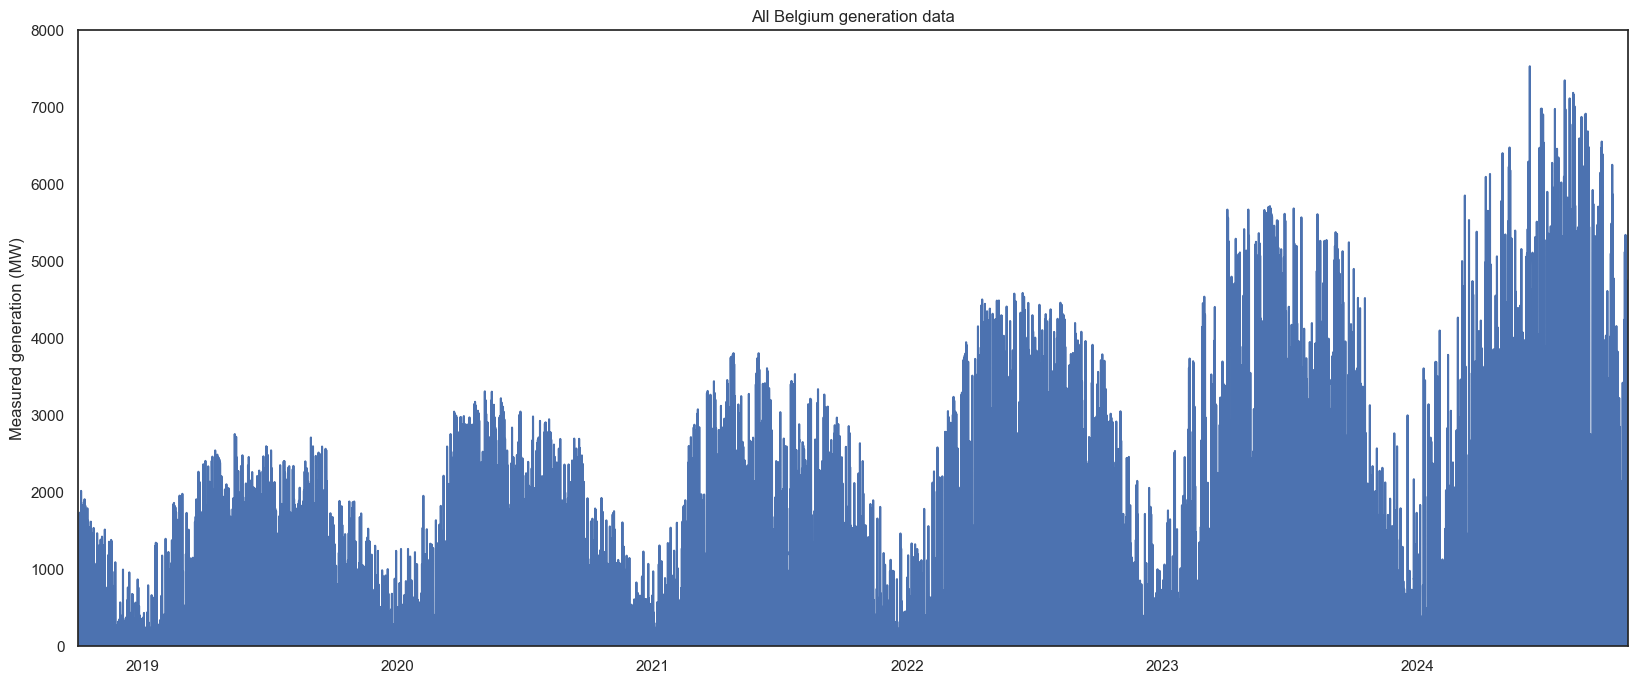

In [8]:
plt.figure(figsize=(20,8))
sns.lineplot(df_be.measured)
plt.ylabel('Measured generation (MW)')
plt.ylim(0,8000)
plt.xlabel('')
plt.xlim(df_be.iloc[0].name,df_be.iloc[-1].name)
plt.title('All Belgium generation data')
plt.show()

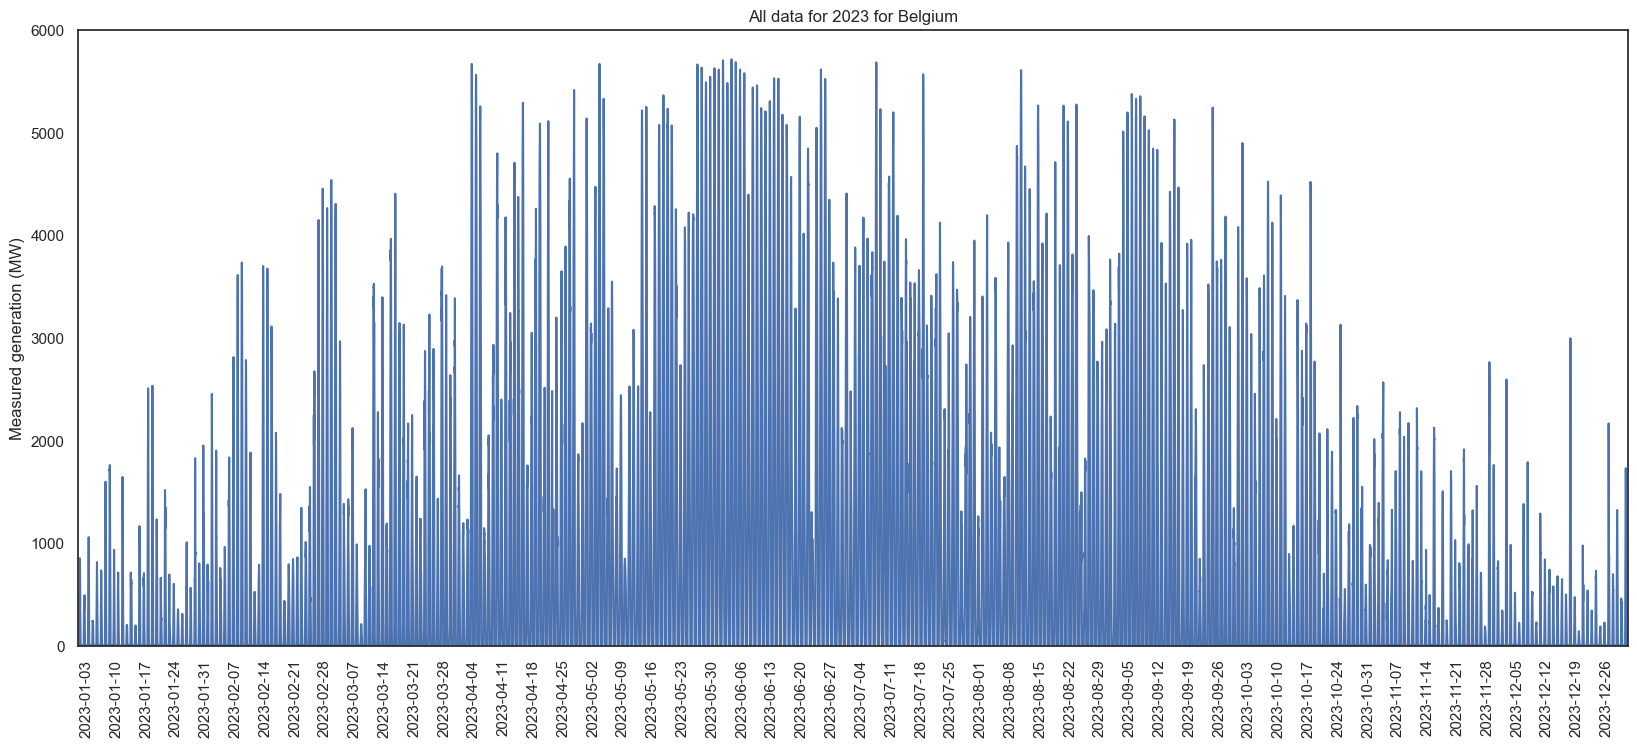

In [159]:
plt.figure(figsize=(20,8))
sns.lineplot(df_be['2023-01-01':'2023-12-31'].measured)
plt.ylabel('Measured generation (MW)')
plt.ylim(0,6000)
plt.xlabel('')
plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2023-12-31'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.xticks(rotation=90)
plt.title('All data for 2023 for Belgium')
plt.show()

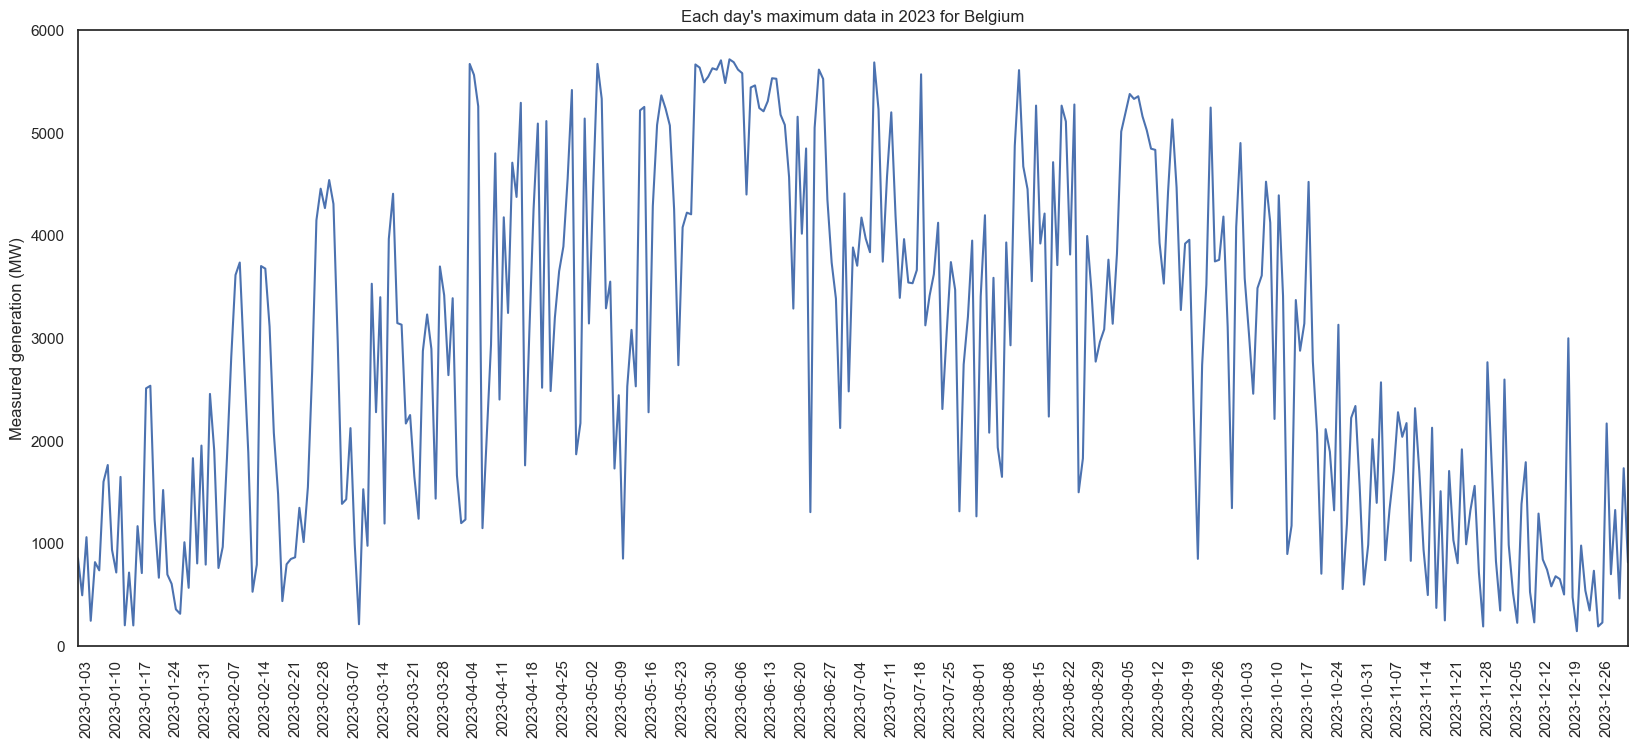

In [160]:
plt.figure(figsize=(20,8))
sns.lineplot(df_be['2023-01-01':'2023-12-31'].measured.resample('D').max())
plt.ylabel('Measured generation (MW)')
plt.ylim(0,6000)
plt.xlabel('')
plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2023-12-31'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.xticks(rotation=90)
plt.title("Each day's maximum data in 2023 for Belgium")
plt.show()

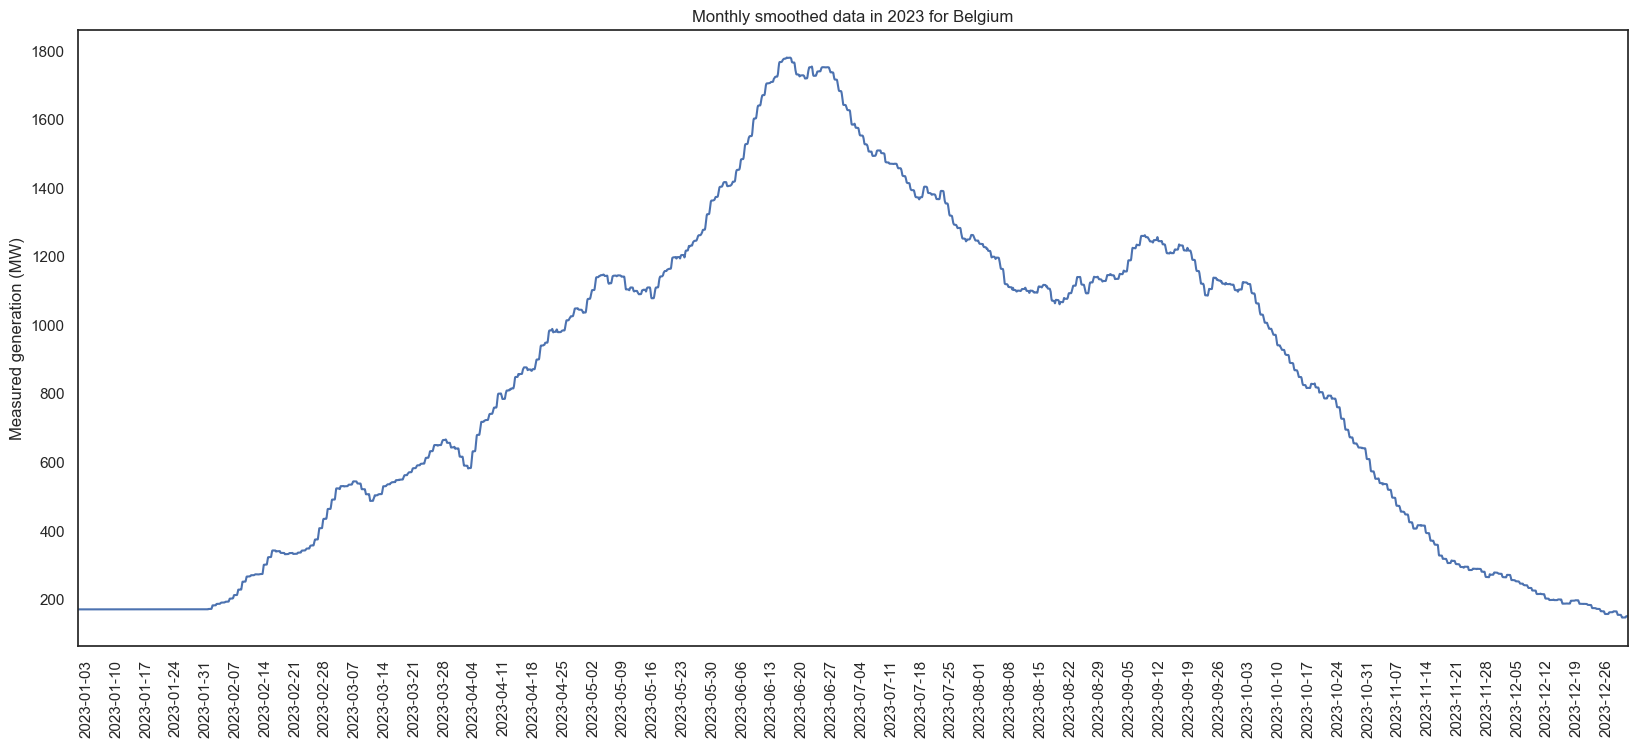

In [19]:
plt.figure(figsize=(20,8))
sns.lineplot(df_be['2023-01-01':'2023-12-31'].measured.rolling(window=96*30).mean().bfill())
plt.ylabel('Measured generation (MW)')
plt.xlabel('')
plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2023-12-31'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.xticks(rotation=90)
plt.title("Monthly smoothed data in 2023 for Belgium")
plt.show()

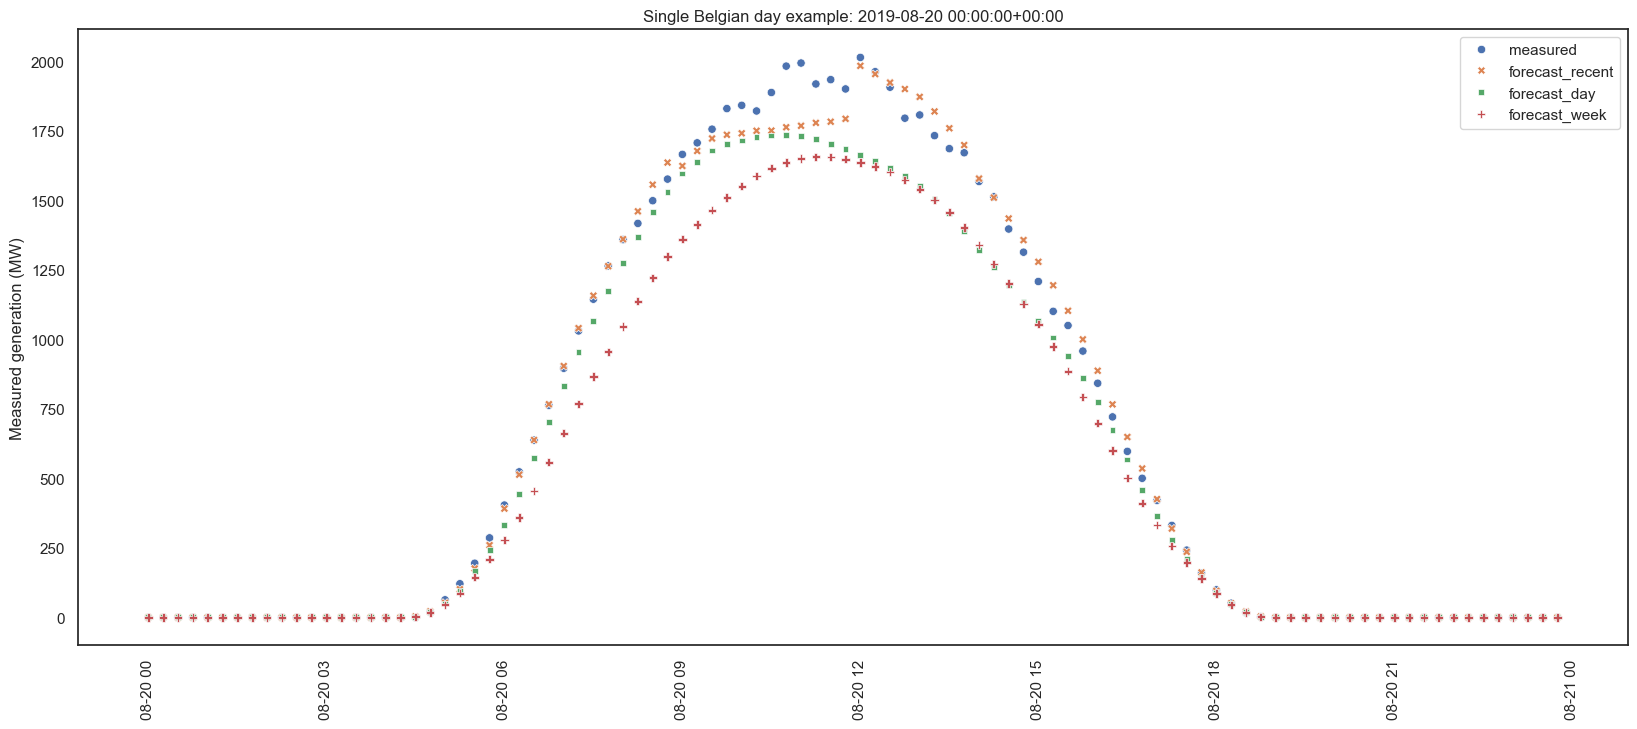

In [ ]:
plt.figure(figsize=(20,8))
random_date = random.choice(df_be.index.normalize().unique())
sns.scatterplot(df_be[['measured','forecast_recent','forecast_day','forecast_week']][df_be.index.normalize() == random_date])
plt.ylabel('Measured generation (MW)')
plt.xlabel('')
plt.xticks(rotation=90)
plt.title(f'Single Belgian day example: {random_date}')
plt.show()

## Grouped by timeframe

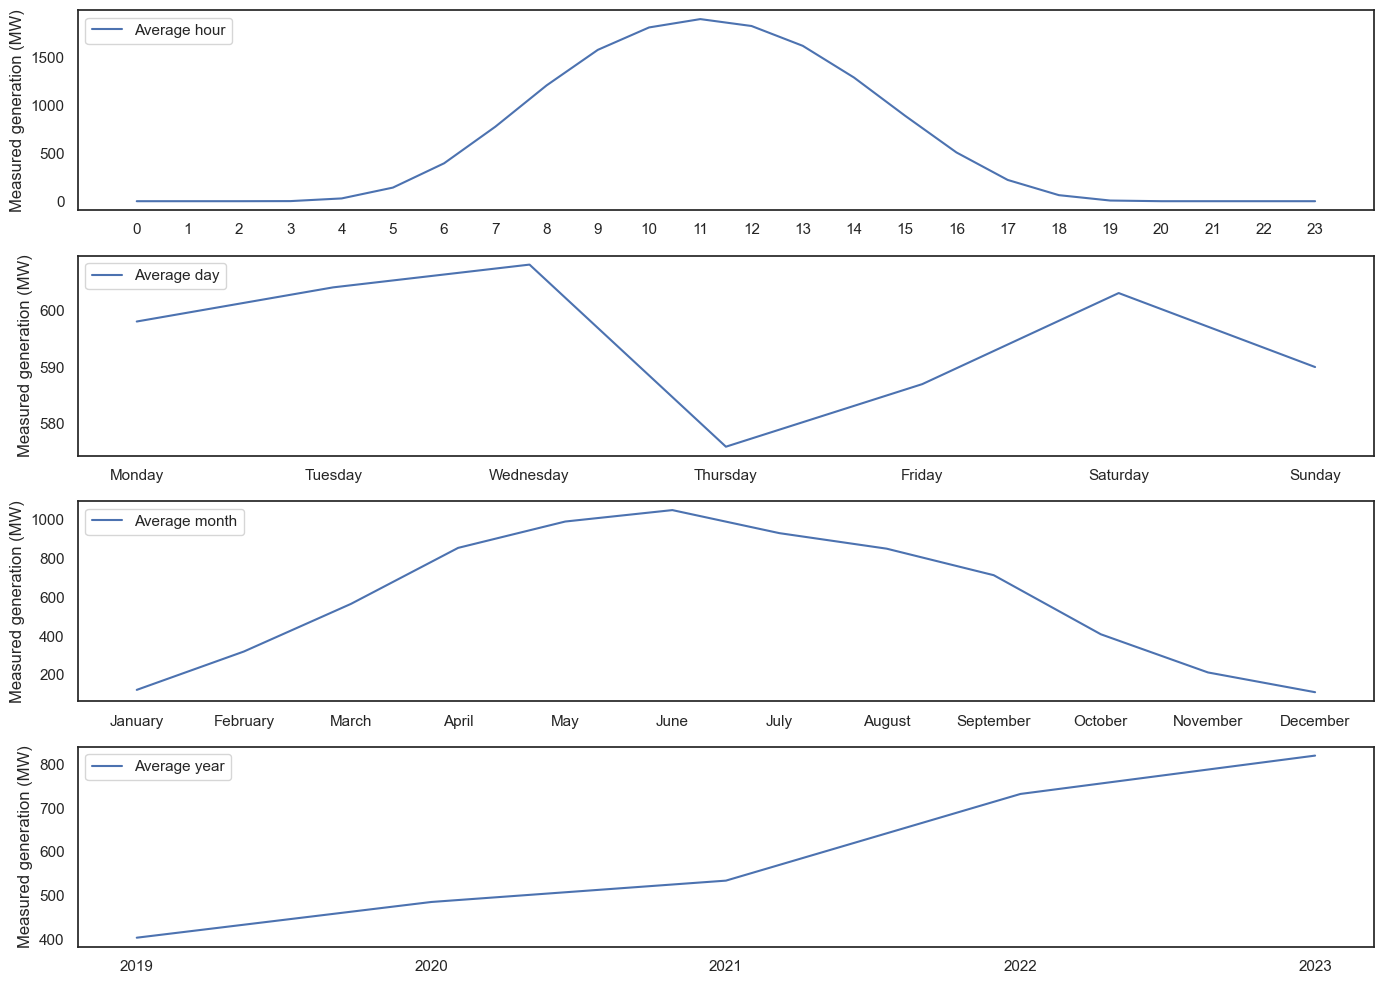

In [9]:
df_timeframe = df_be_fullyears.copy()
df_timeframe['hour'] = df_be_fullyears.index.hour
df_timeframe['day_of_week'] = df_be_fullyears.index.dayofweek
df_timeframe['month'] = df_be_fullyears.index.month
df_timeframe['year'] = df_be_fullyears.index.year

df_timeframe_hour = df_timeframe.groupby('hour').mean()[['measured']].round()
df_timeframe_day_of_week = df_timeframe.groupby('day_of_week').mean()[['measured']].round()
df_timeframe_day_of_week.index = pd.Index(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
df_timeframe_month = df_timeframe.groupby('month').mean()[['measured']].round()
df_timeframe_month.index = pd.Index(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
df_timeframe_year = df_timeframe.groupby('year').mean()[['measured']].round()

plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(df_timeframe_hour, label='Average hour')
plt.ylabel('Measured generation (MW)')
plt.xticks(np.arange(min(df_timeframe_hour.index), max(df_timeframe_hour.index) + 1, 1))
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(df_timeframe_day_of_week, label='Average day')
plt.ylabel('Measured generation (MW)')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(df_timeframe_month, label='Average month')
plt.ylabel('Measured generation (MW)')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(df_timeframe_year, label='Average year')
plt.ylabel('Measured generation (MW)')
plt.xticks(np.arange(min(df_timeframe_year.index), max(df_timeframe_year.index) + 1, 1))
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Variations

In [10]:
cv = df_be_fullyears.measured.std() / df_be_fullyears.measured.mean()
print(f"Coefficient of Variation\t{cv:.3f}")
hourly_variation = df_be_fullyears.measured.resample('h').std()
print(f"Average Hourly Variation\t{hourly_variation.mean():.3f}")
daily_variation = df_be_fullyears.measured.resample('D').std()
print(f"Average Daily Variation\t\t{daily_variation.mean():.3f}")
monthly_variation = df_be_fullyears.measured.resample('ME').std()
print(f"Average Monthly Variation\t{monthly_variation.mean():.3f}")
iqr = df_be_fullyears.measured.quantile(0.75) - df_be_fullyears.measured.quantile(0.25)
print(f"Interquartile Range (IQR)\t{iqr:.3f}")

Coefficient of Variation	1.672
Average Hourly Variation	57.516
Average Daily Variation		737.438
Average Monthly Variation	814.156
Interquartile Range (IQR)	851.291


## STL decomposition

In [169]:
df_be_stl = df_be_fullyears.measured.copy()
df_be_stl = df_be_stl.resample('h').mean().asfreq('h')

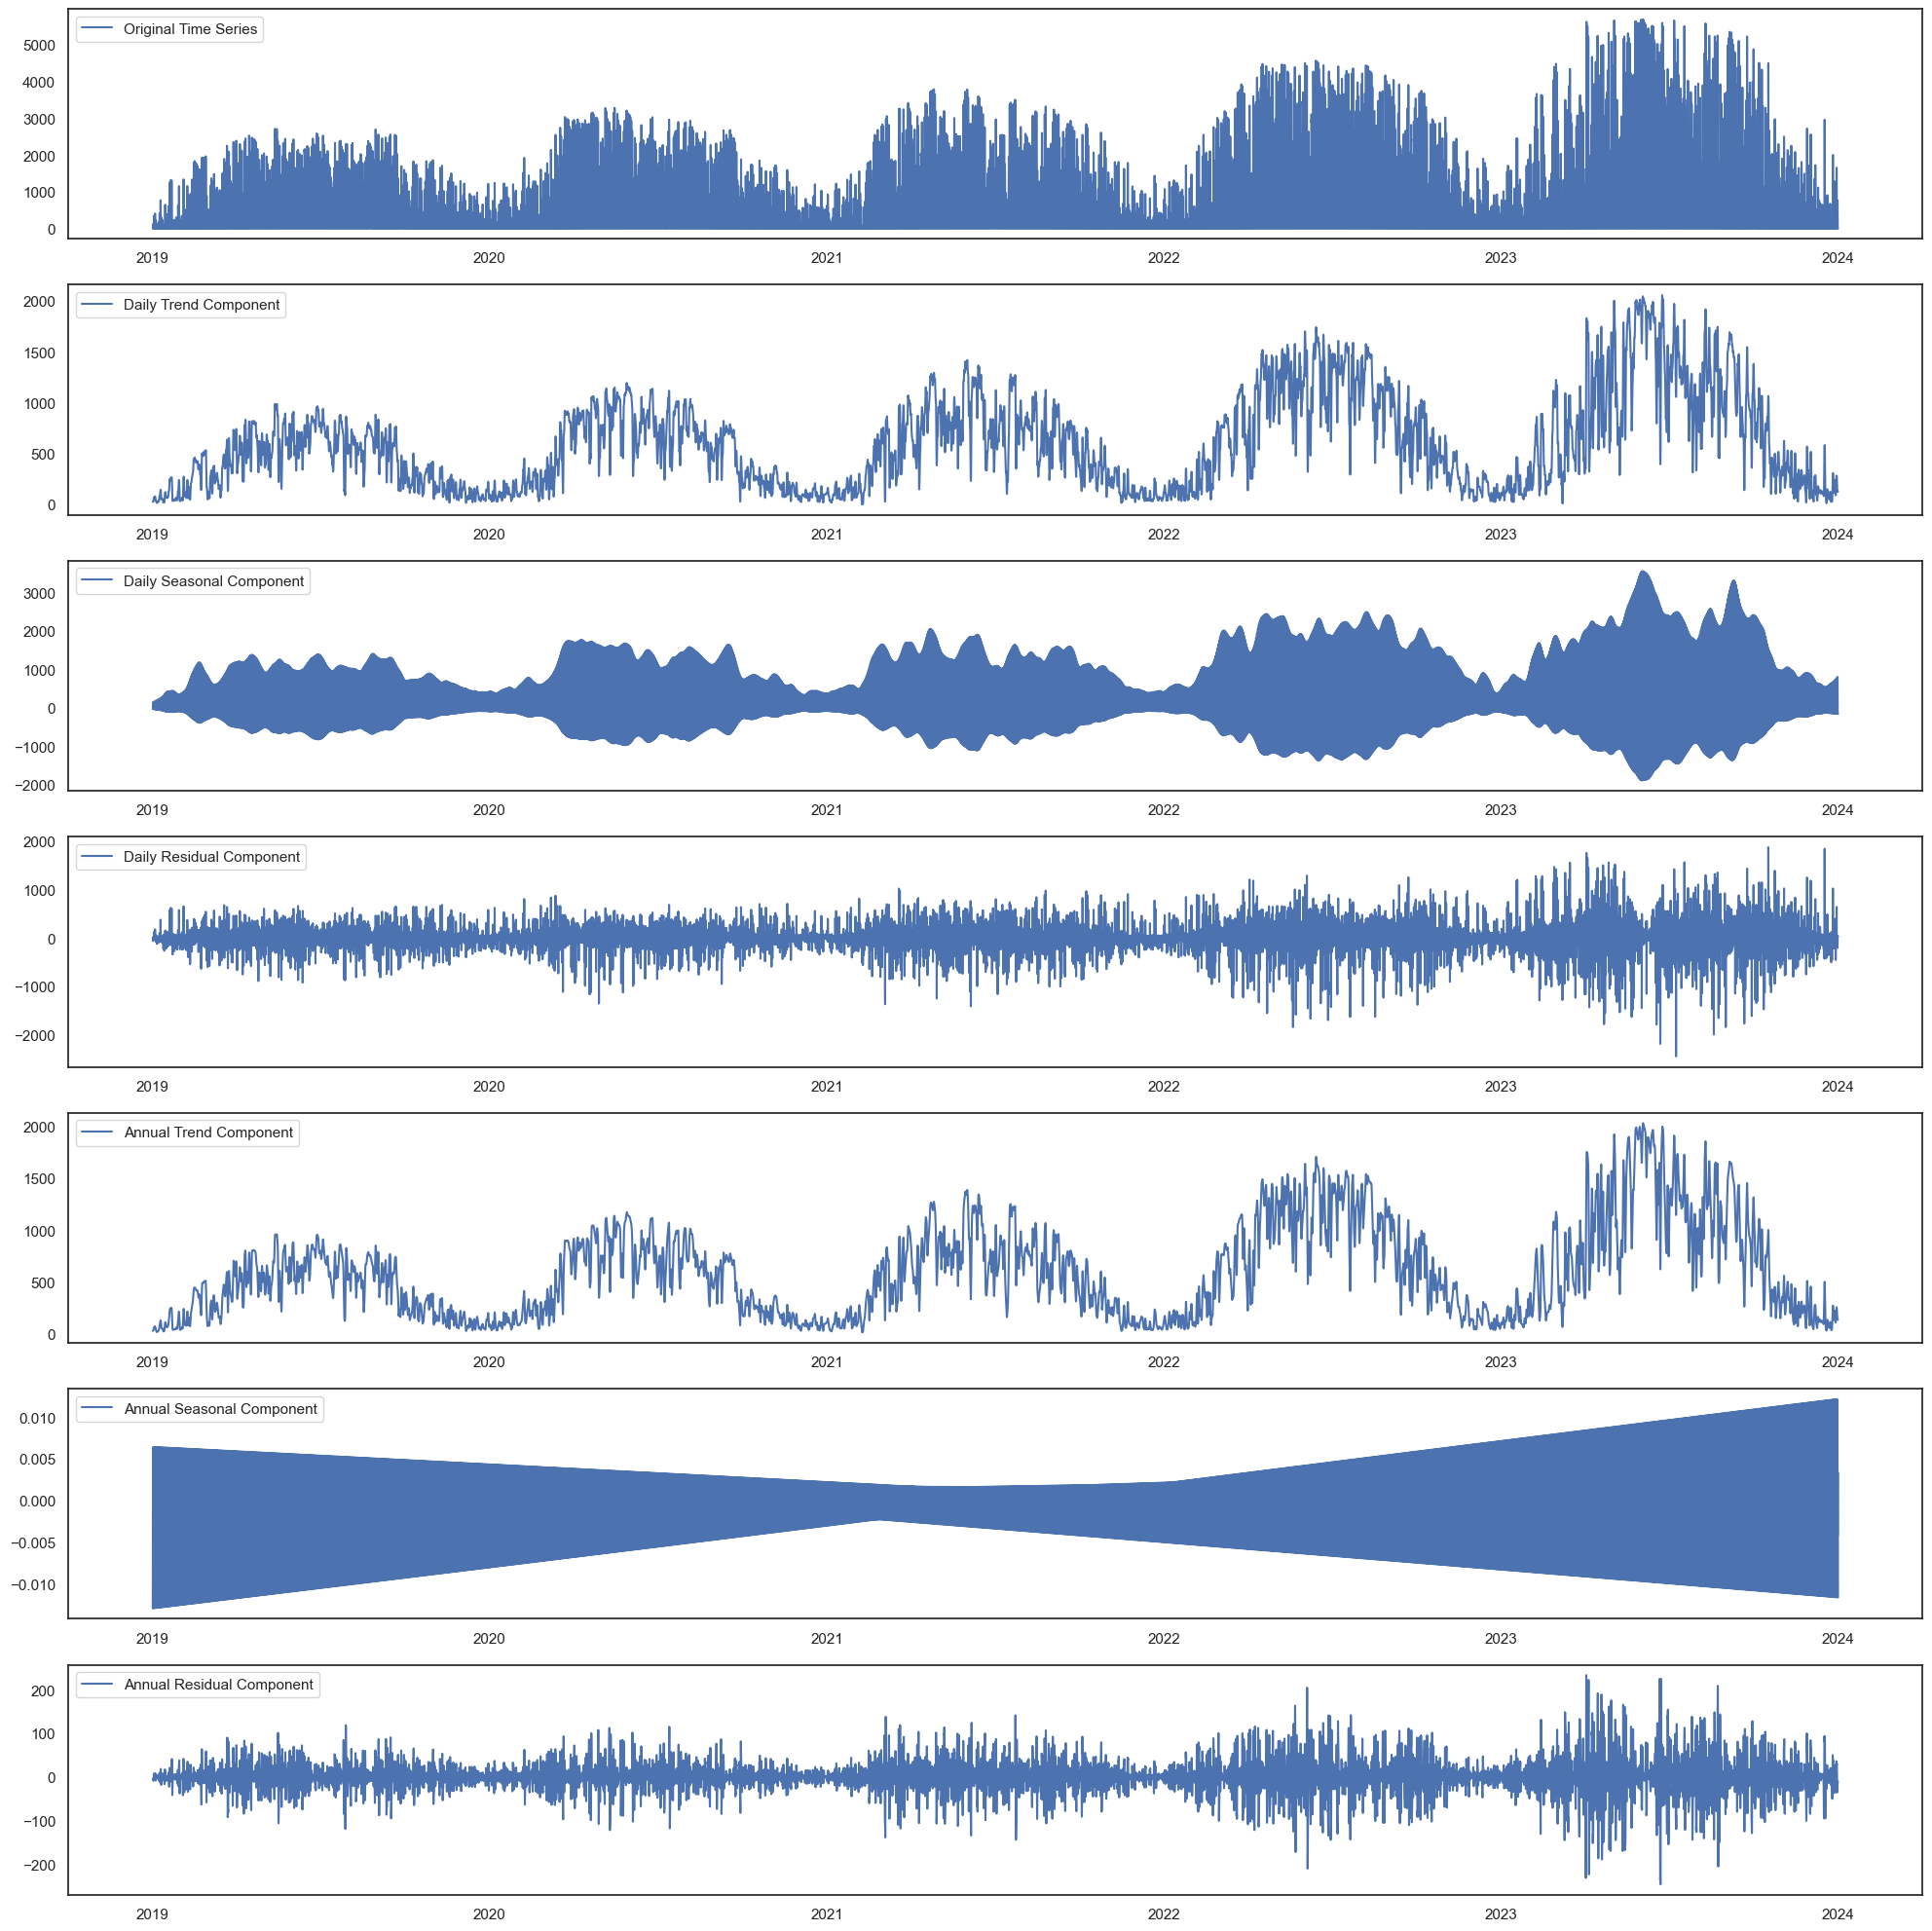

In [188]:
stl_daily = STL(df_be_stl, seasonal=23) # ~24hrs, but needs to be odd - 23 was better than 25
result_daily = stl_daily.fit()

stl_annual = STL(result_daily.trend, seasonal=8759) # £8760hrs / year
result_annual = stl_annual.fit()

daily_trend = result_daily.trend
daily_seasonal = result_daily.seasonal
daily_residual = result_daily.resid

annual_trend = result_annual.trend
annual_seasonal = result_annual.seasonal
annual_residual = result_annual.resid

plt.figure(figsize=(20, 20))
plt.subplot(711)
plt.plot(df_be_stl, label='Original Time Series')
plt.legend(loc='upper left')
plt.subplot(712)
plt.plot(daily_trend, label='Daily Trend Component')
plt.legend(loc='upper left')
plt.subplot(713)
plt.plot(daily_seasonal, label='Daily Seasonal Component')
plt.legend(loc='upper left')
plt.subplot(714)
plt.plot(daily_residual, label='Daily Residual Component')
plt.legend(loc='upper left')
plt.subplot(715)
plt.plot(annual_trend, label='Annual Trend Component')
plt.legend(loc='upper left')
plt.subplot(716)
plt.plot(annual_seasonal, label='Annual Seasonal Component')
plt.legend(loc='upper left')
plt.subplot(717)
plt.plot(annual_residual, label='Annual Residual Component')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

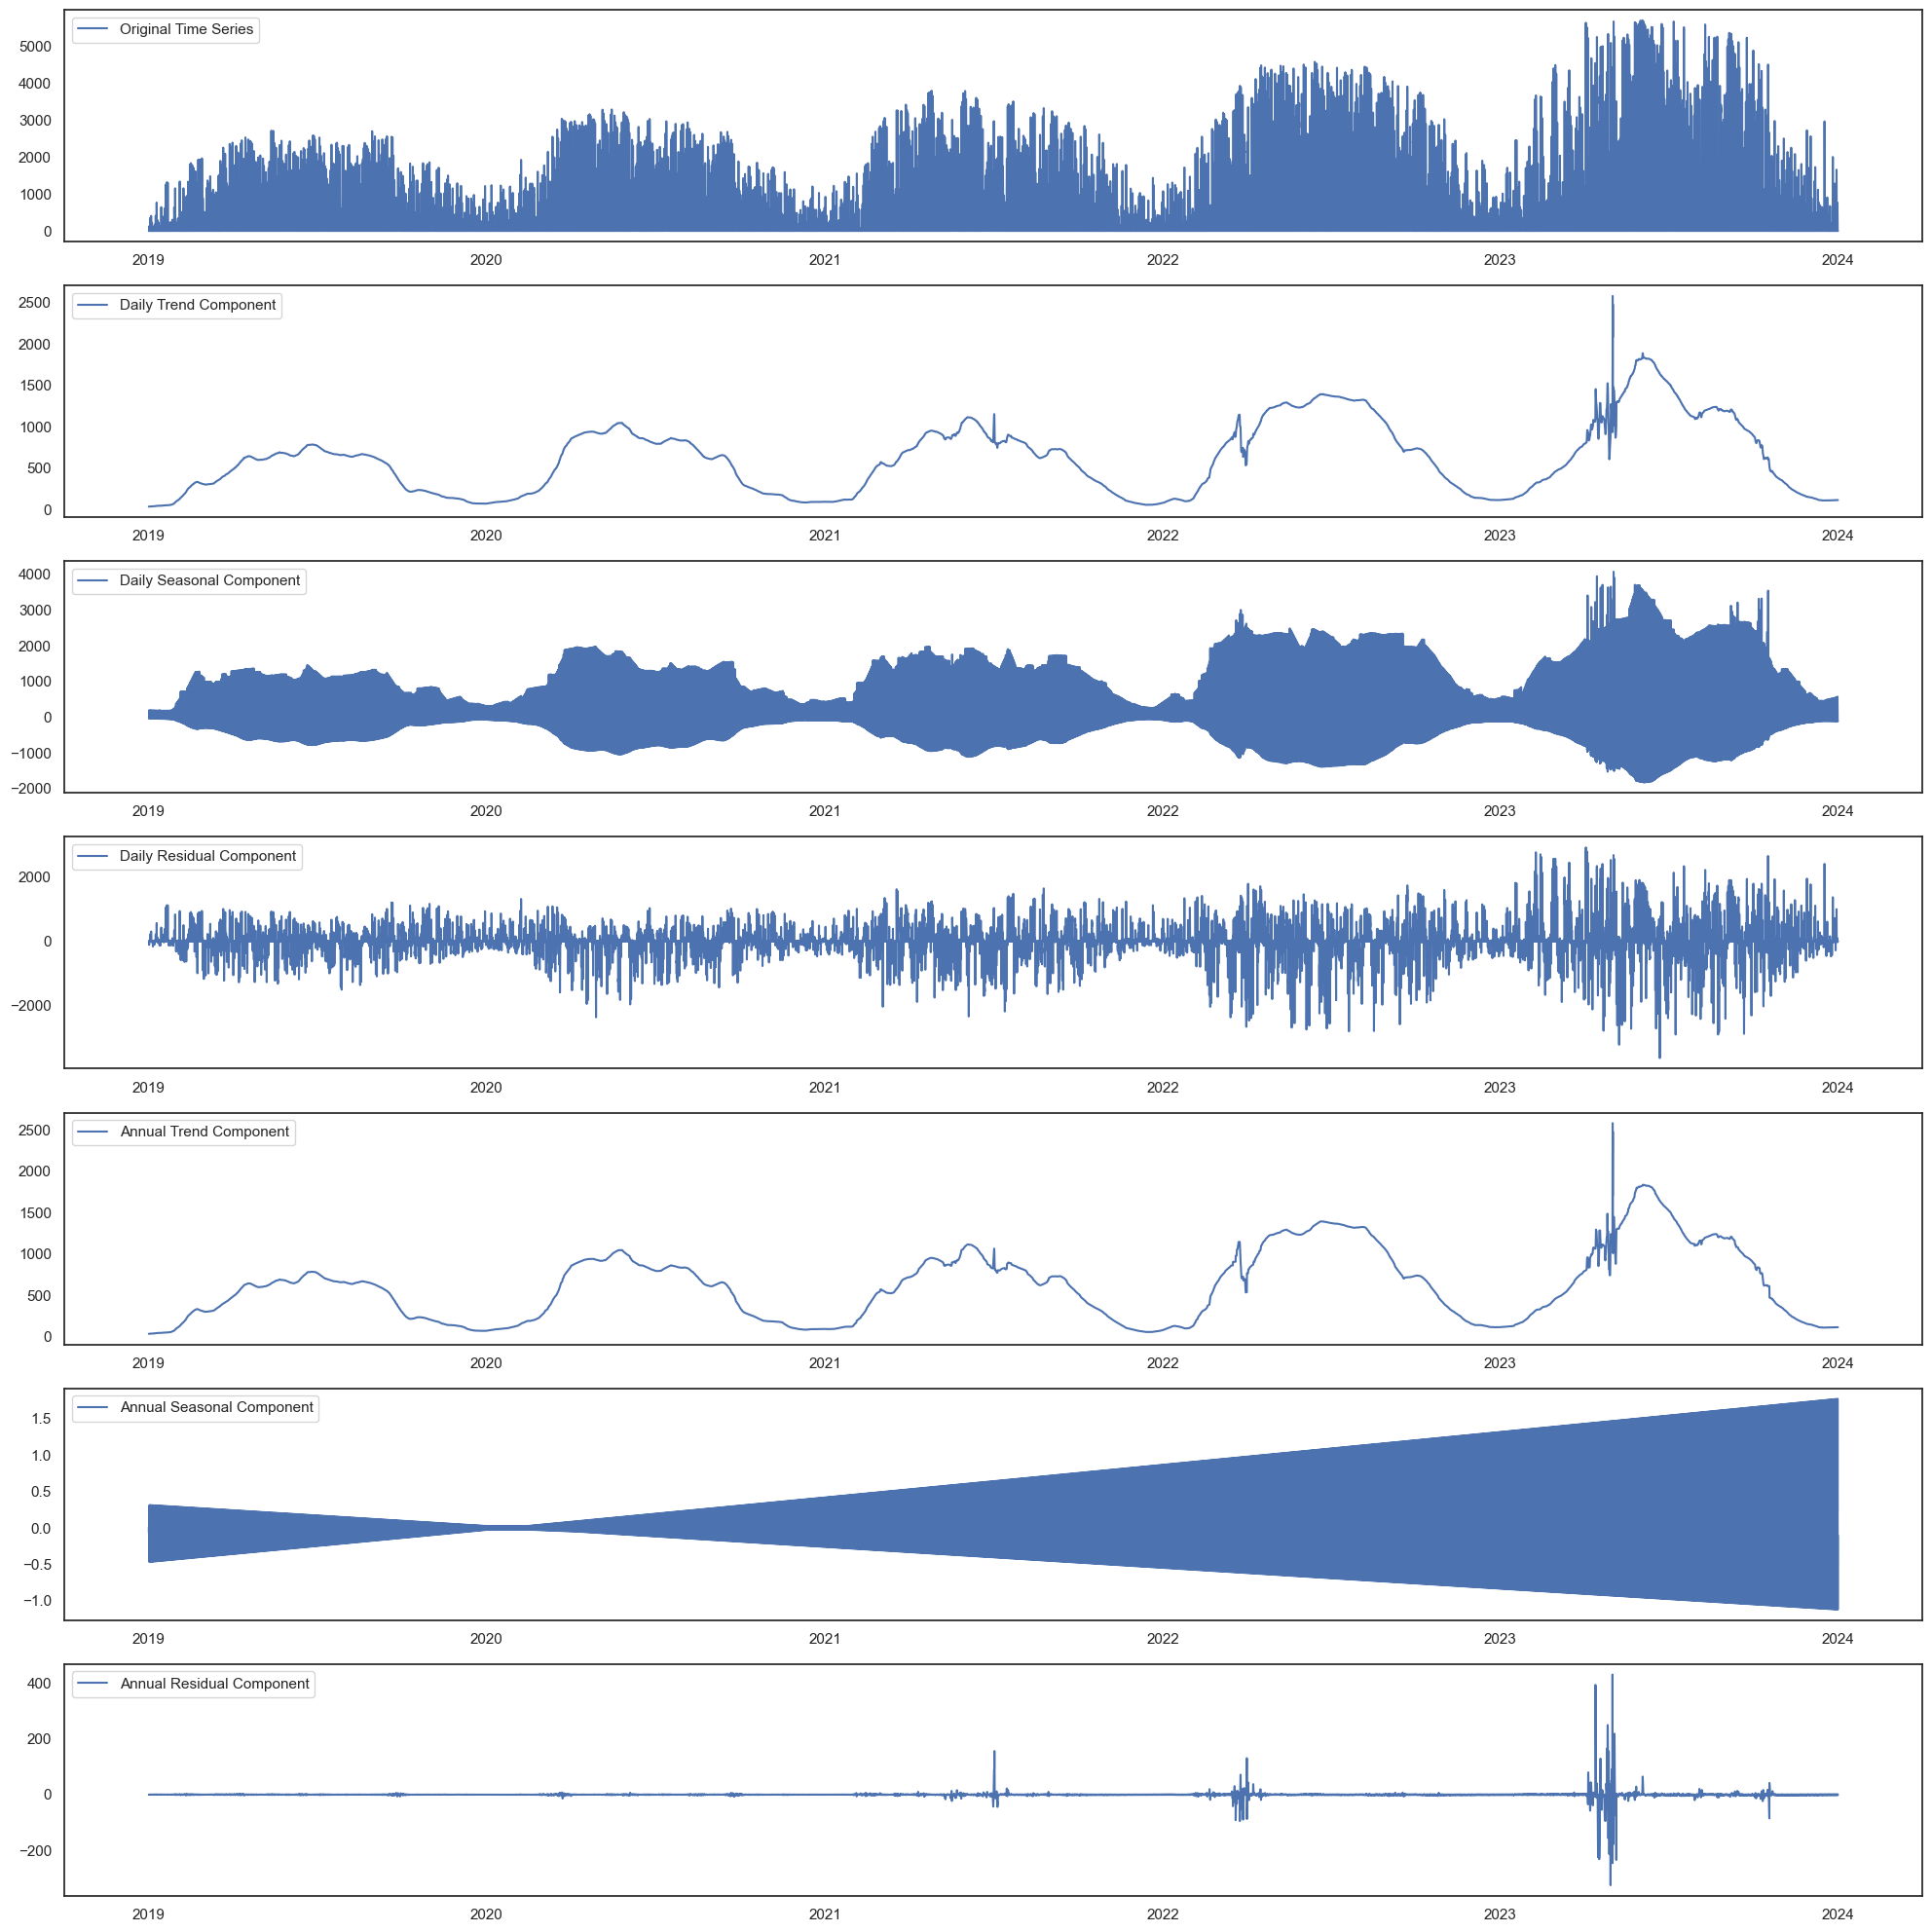

In [190]:
stl_daily = STL(df_be_stl, seasonal=23, robust=True) # ~24hrs, but needs to be odd - 23 was better than 25
result_daily = stl_daily.fit()

stl_annual = STL(result_daily.trend, seasonal=8759, robust=True) # £8760hrs / year
result_annual = stl_annual.fit()

daily_trend = result_daily.trend
daily_seasonal = result_daily.seasonal
daily_residual = result_daily.resid

annual_trend = result_annual.trend
annual_seasonal = result_annual.seasonal
annual_residual = result_annual.resid

plt.figure(figsize=(20, 20))
plt.subplot(711)
plt.plot(df_be_stl, label='Original Time Series')
plt.legend(loc='upper left')
plt.subplot(712)
plt.plot(daily_trend, label='Daily Trend Component')
plt.legend(loc='upper left')
plt.subplot(713)
plt.plot(daily_seasonal, label='Daily Seasonal Component')
plt.legend(loc='upper left')
plt.subplot(714)
plt.plot(daily_residual, label='Daily Residual Component')
plt.legend(loc='upper left')
plt.subplot(715)
plt.plot(annual_trend, label='Annual Trend Component')
plt.legend(loc='upper left')
plt.subplot(716)
plt.plot(annual_seasonal, label='Annual Seasonal Component')
plt.legend(loc='upper left')
plt.subplot(717)
plt.plot(annual_residual, label='Annual Residual Component')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Visualised distributions

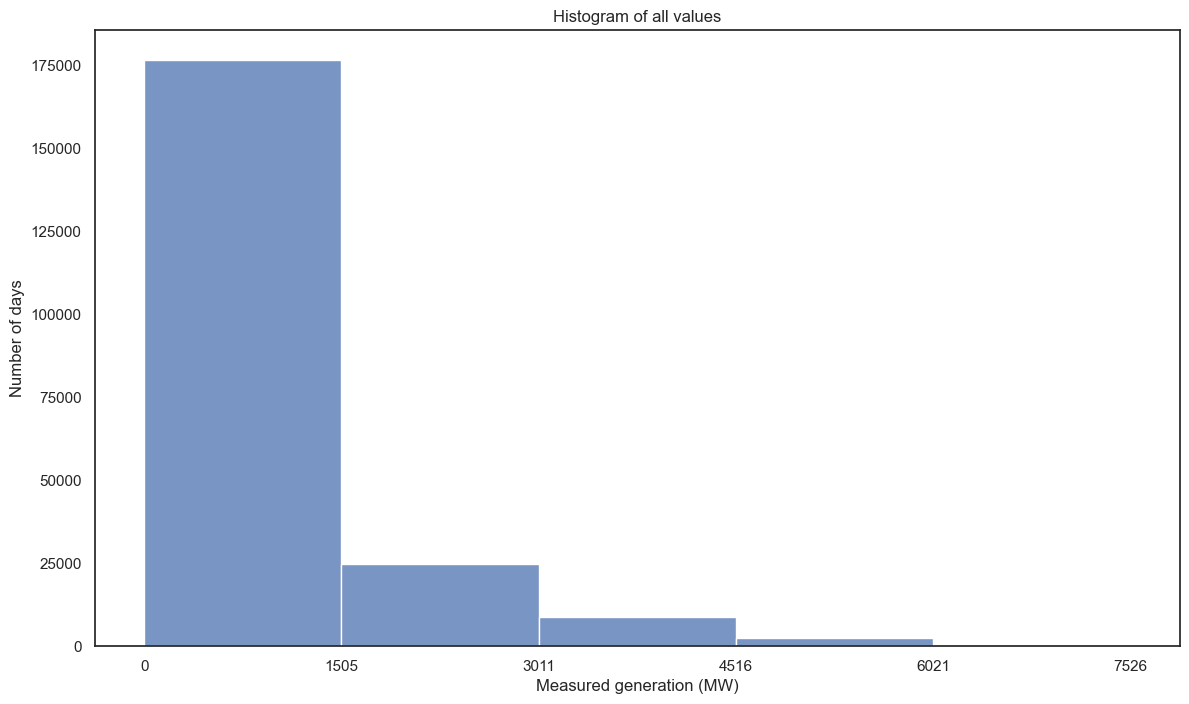

In [11]:
df_be_max = df_be.measured.max()
bins = [0, 0.2*df_be_max, 0.4*df_be_max, 0.6*df_be_max, 0.8*df_be_max, df_be_max]
plt.figure(figsize=(14,8))
sns.histplot(df_be.measured, bins=bins, kde=False)
plt.title('Histogram of all values')
plt.ylabel('Number of days')
plt.xlabel('Measured generation (MW)')
plt.xticks(bins)
plt.show()

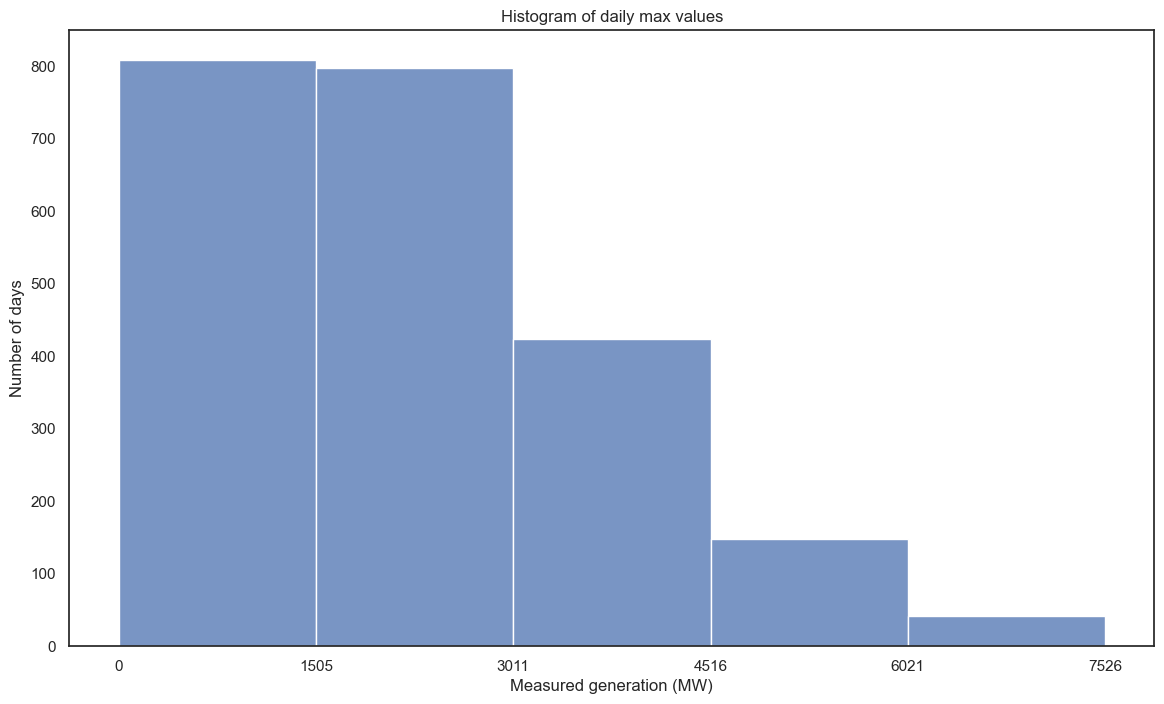

In [213]:
daily_max_df = df_be[['measured']].resample('D').max()
total_max = daily_max_df.measured.max()
bins = [0, 0.2*total_max, 0.4*total_max, 0.6*total_max, 0.8*total_max, total_max]
plt.figure(figsize=(14,8))
sns.histplot(daily_max_df.measured, bins=bins, kde=False)
plt.title('Histogram of daily max values')
plt.ylabel('Number of days')
plt.xlabel('Measured generation (MW)')
plt.xticks(bins)
plt.show()

80-100:	3936
60-80:	14208
40-60:	40704
20-40:	76512
0-20:	77664


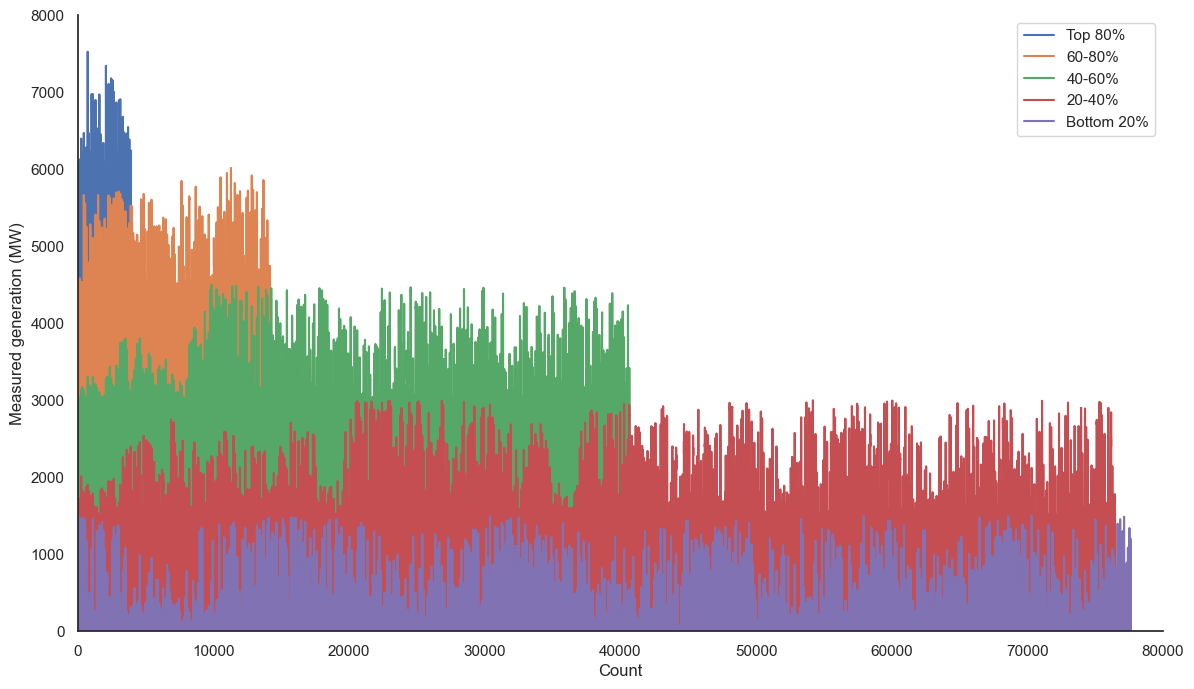

In [203]:
daily_max = df_be.measured.resample('D').max()
total_max = daily_max.max()

pc_80_100 = daily_max[daily_max >= total_max*0.8].index
pc_60_80 = daily_max[(daily_max >= total_max*0.6) & (daily_max < total_max*0.8)].index
pc_40_60 = daily_max[(daily_max >= total_max*0.4) & (daily_max < total_max*0.6)].index
pc_20_40 = daily_max[(daily_max >= total_max*0.2) & (daily_max < total_max*0.4)].index
pc_0_20 = daily_max[(daily_max < total_max*0.2)].index

df_pc_80_100 = df_be[df_be.index.normalize().isin(pc_80_100)]
df_pc_80_100 = df_pc_80_100.reset_index(drop=True)
df_pc_80_100['datetime'] = pd.date_range(start="2023-01-01", periods=len(df_pc_80_100), freq="15min")
df_pc_80_100.reset_index()
print(f'80-100:\t{len(df_pc_80_100)}')

df_pc_60_80 = df_be[df_be.index.normalize().isin(pc_60_80)]
df_pc_60_80 = df_pc_60_80.reset_index(drop=True)
df_pc_60_80.reset_index()
print(f'60-80:\t{len(df_pc_60_80)}')

df_pc_40_60 = df_be[df_be.index.normalize().isin(pc_40_60)]
df_pc_40_60 = df_pc_40_60.reset_index(drop=True)
df_pc_40_60.reset_index()
print(f'40-60:\t{len(df_pc_40_60)}')

df_pc_20_40 = df_be[df_be.index.normalize().isin(pc_20_40)]
df_pc_20_40 = df_pc_20_40.reset_index(drop=True)
df_pc_20_40.reset_index()
print(f'20-40:\t{len(df_pc_20_40)}')

df_pc_0_20 = df_be[df_be.index.normalize().isin(pc_0_20)]
df_pc_0_20 = df_pc_0_20.reset_index(drop=True)
df_pc_0_20.reset_index()
print(f'0-20:\t{len(df_pc_0_20)}')

plt.figure(figsize=(14,8))
sns.lineplot(df_pc_80_100.measured, label='Top 80%')
sns.lineplot(df_pc_60_80.measured, label='60-80%')
sns.lineplot(df_pc_40_60.measured, label='40-60%')
sns.lineplot(df_pc_20_40.measured, label='20-40%')
sns.lineplot(df_pc_0_20.measured, label='Bottom 20%')
sns.despine()
plt.ylabel('Measured generation (MW)')
plt.xlabel('Count')
plt.xlim(0,80000)
plt.ylim(0,8000)
plt.legend(loc='upper right')
plt.show()

## Stationarity

In [12]:
adfuller(df_be.measured, autolag='AIC')

(-11.94507306500257,
 4.449909467141862e-22,
 82,
 212941,
 {'1%': -3.4303807098155406,
  '5%': -2.8615535733366726,
  '10%': -2.5667772245983227},
 2141580.3188957865)

# Their forecasts

### Plots

In [63]:
def plot_forecast_vs_measured(df, col_measured, col_forecast, title):
    region_max = df.groupby('region').measured.max().sort_values(ascending=False)
    plt.figure(figsize=(10, 10))
    plt.title(title)
    axes_buffer = 200
    max_value = max(df[col_forecast].max(), df[col_measured].max())
    max_limit = np.ceil(max_value)+axes_buffer
    for region in region_max.index.values:
        ax = sns.regplot(df[df.region==region], y=col_measured, x=col_forecast, label=region)
    plt.plot([-axes_buffer, max_limit], [-axes_buffer, max_limit], color='black', linestyle='--', linewidth=1)
    plt.ylabel('Measured generation (MW)')
    plt.ylim(-axes_buffer, max_limit)
    plt.yticks(np.arange(0, (np.floor(max_value/1000)*1000)+1, 1000))
    plt.xlabel('Forecast generation (MW)')
    plt.xlim(-axes_buffer, max_limit)
    plt.xticks(np.arange(0, (np.floor(max_value/1000)*1000)+1, 1000))
    plt.legend(loc='upper left')
    plt.show()

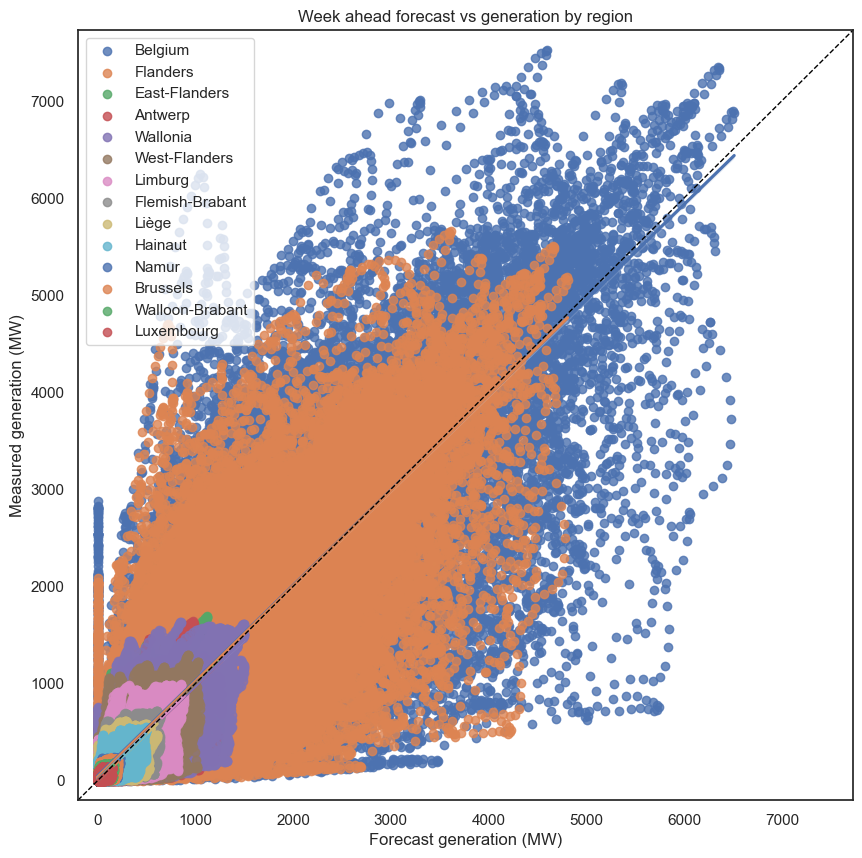

In [64]:
plot_forecast_vs_measured(df, 'measured', 'forecast_week', 'Week ahead forecast vs generation by region')

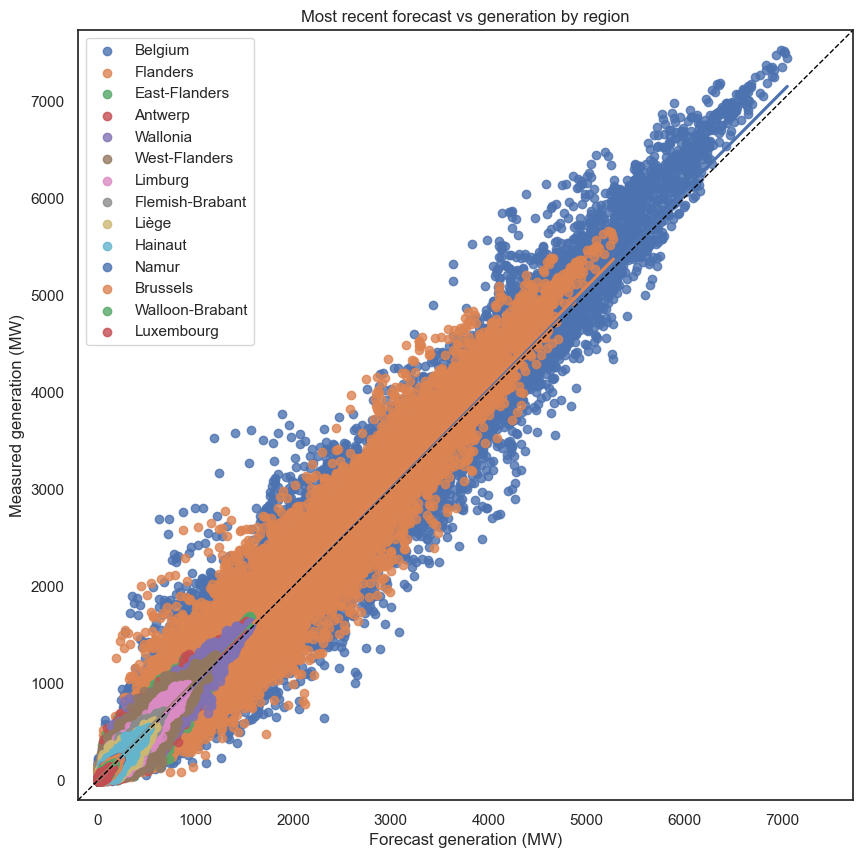

In [67]:
plot_forecast_vs_measured(df, 'measured', 'forecast_recent', 'Most recent forecast vs generation by region')

In [83]:
def plot_forecast_vs_measured_subplots(df, col_measured, col_forecast, title):
    plt.figure(figsize=(20, 20))
    plt.suptitle(title)
    regions = df.region.unique()
    rows, cols = 4, 4
    for i, region in enumerate(regions, 1):
        ax = plt.subplot(rows, cols, i)
        region_data = df[df.region == region]
        max_value = max(region_data[col_forecast].max(), region_data[col_measured].max())
        max_limit = np.ceil(max_value)*1.1
        sns.regplot(data=region_data, x='forecast_week', y='measured')
        plt.plot([0, max_limit], [0, max_limit], color='black', linestyle='--', linewidth=1)
        plt.title(region)
        plt.ylabel('Measured generation (MW)')
        ax.set_ylim(-max_limit*0.1, max_limit)
        plt.xlabel('Forecast generation (MW)')
        ax.set_xlim(-max_limit*0.1, max_limit)
        ax.set_aspect('equal', adjustable='box')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

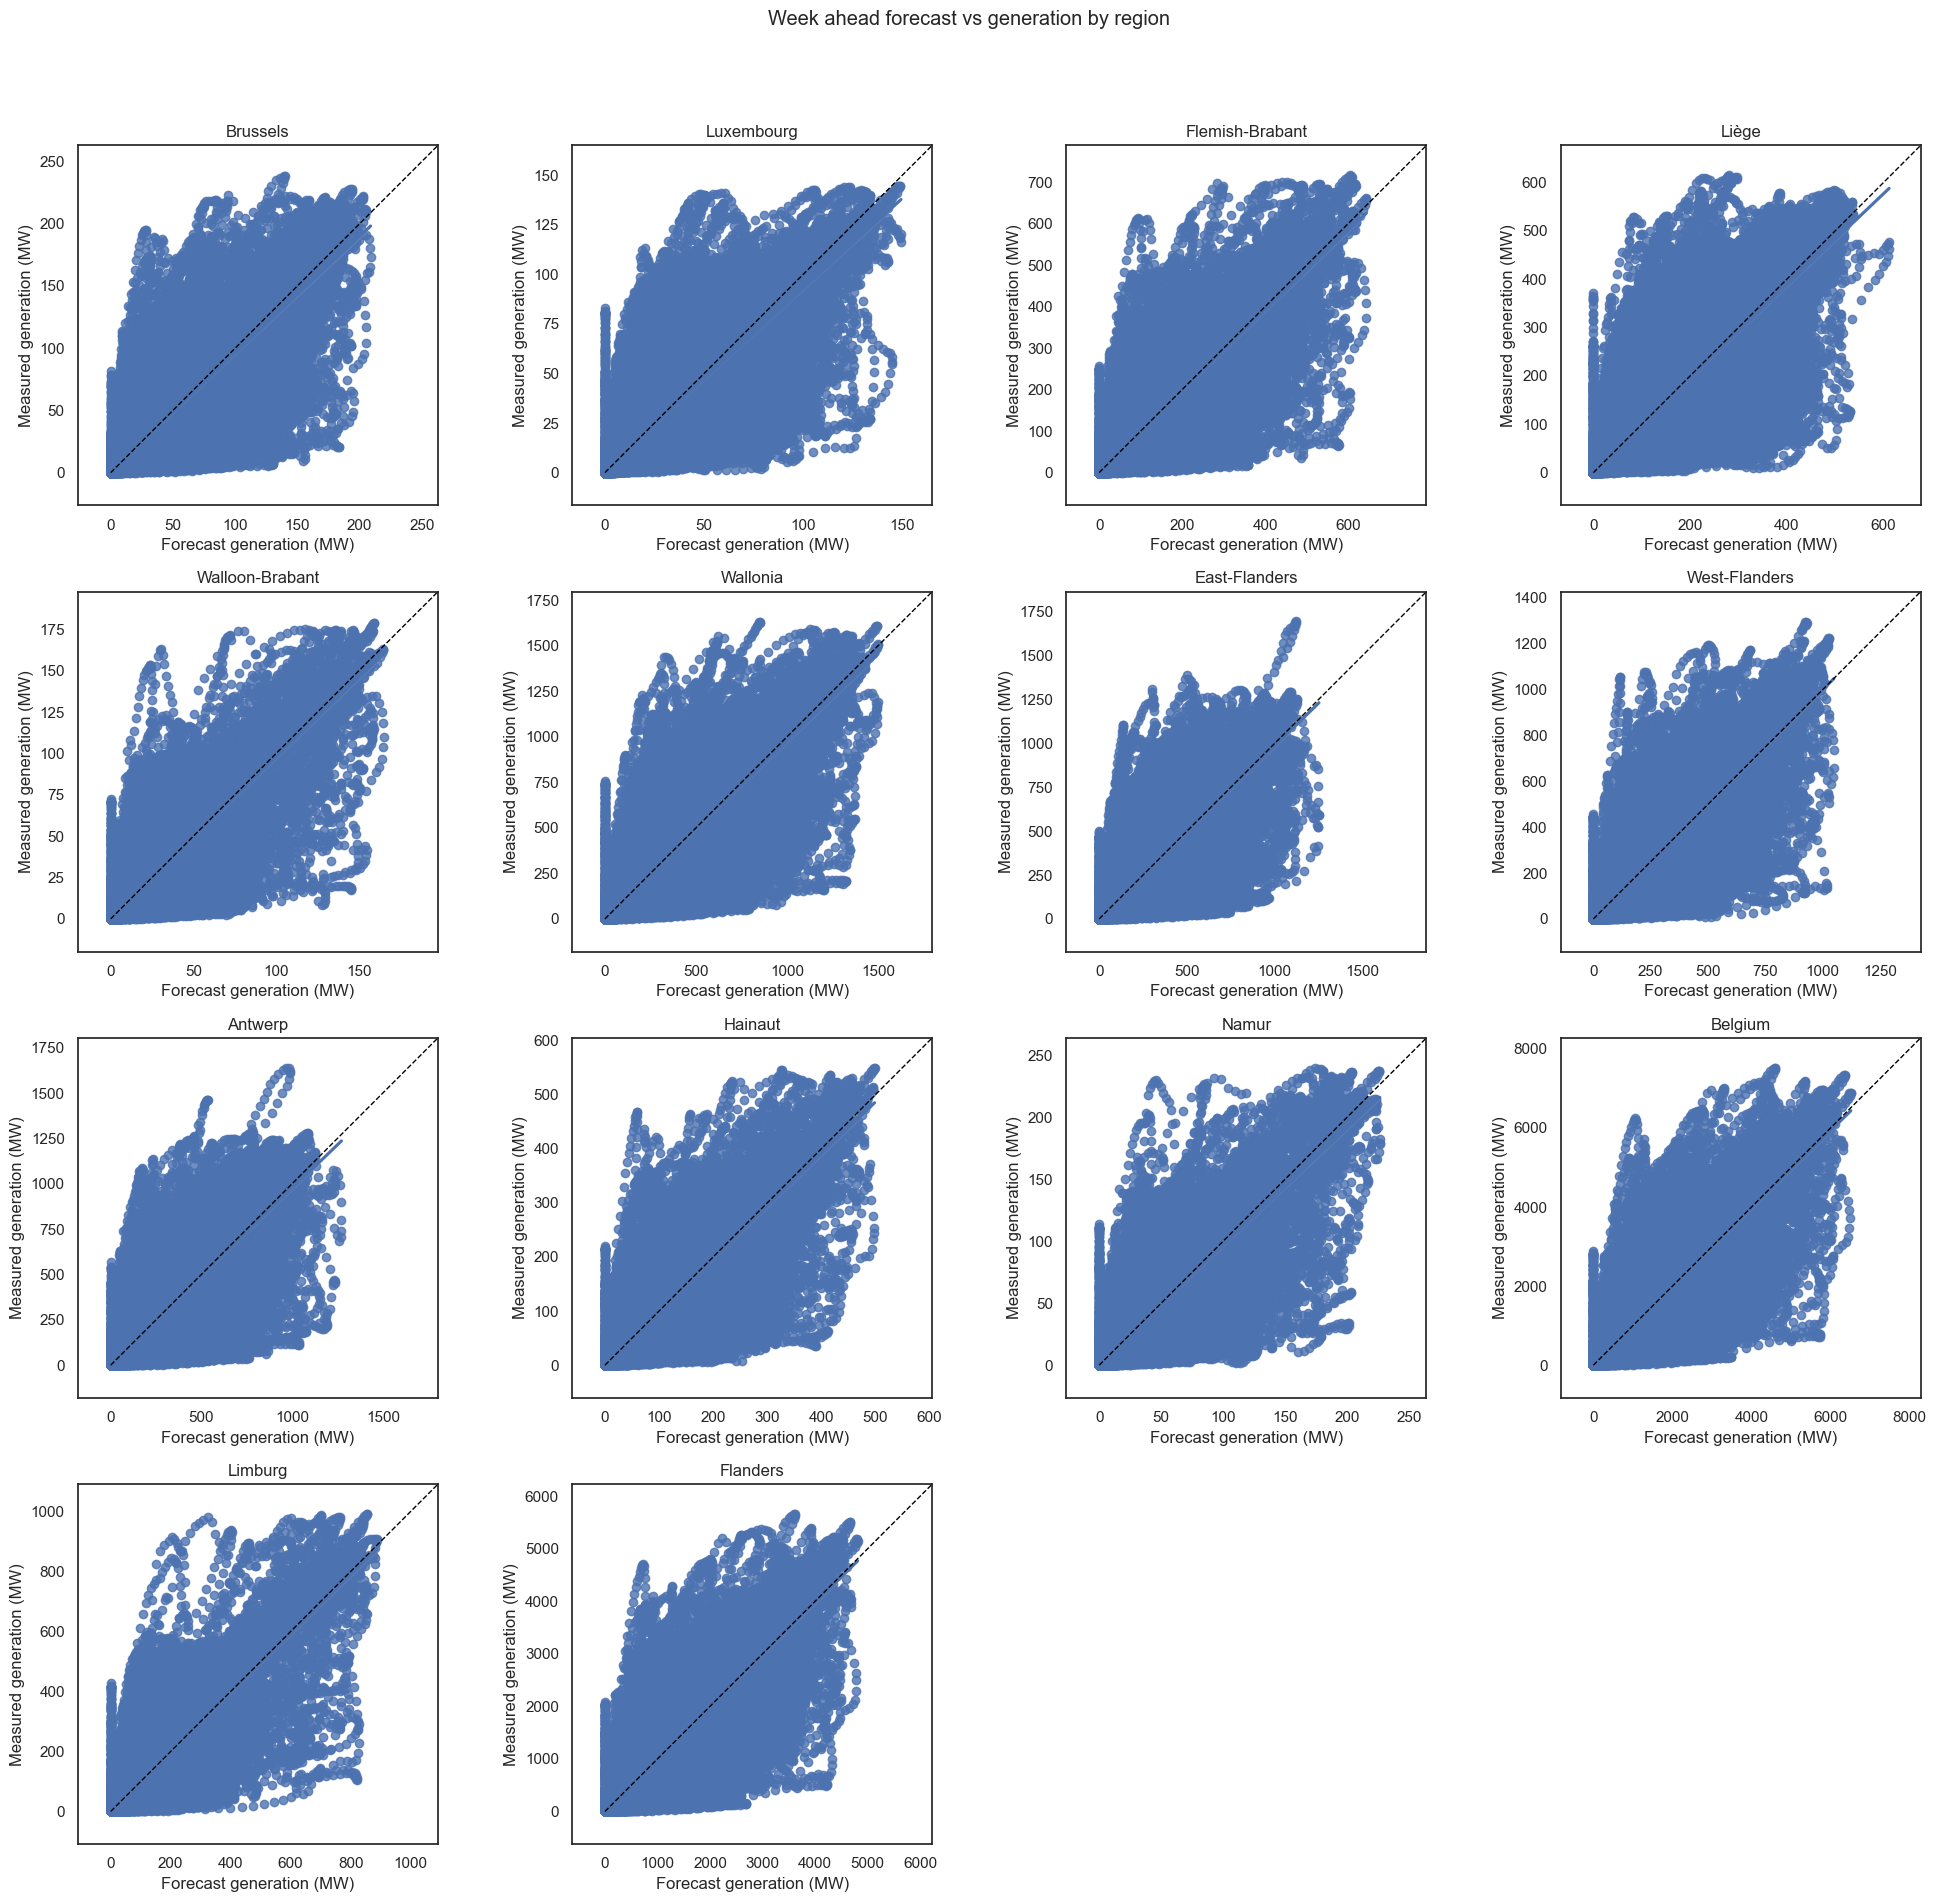

In [84]:
plot_forecast_vs_measured_subplots(df, 'measured', 'forecast_week', 'Week ahead forecast vs generation by region')

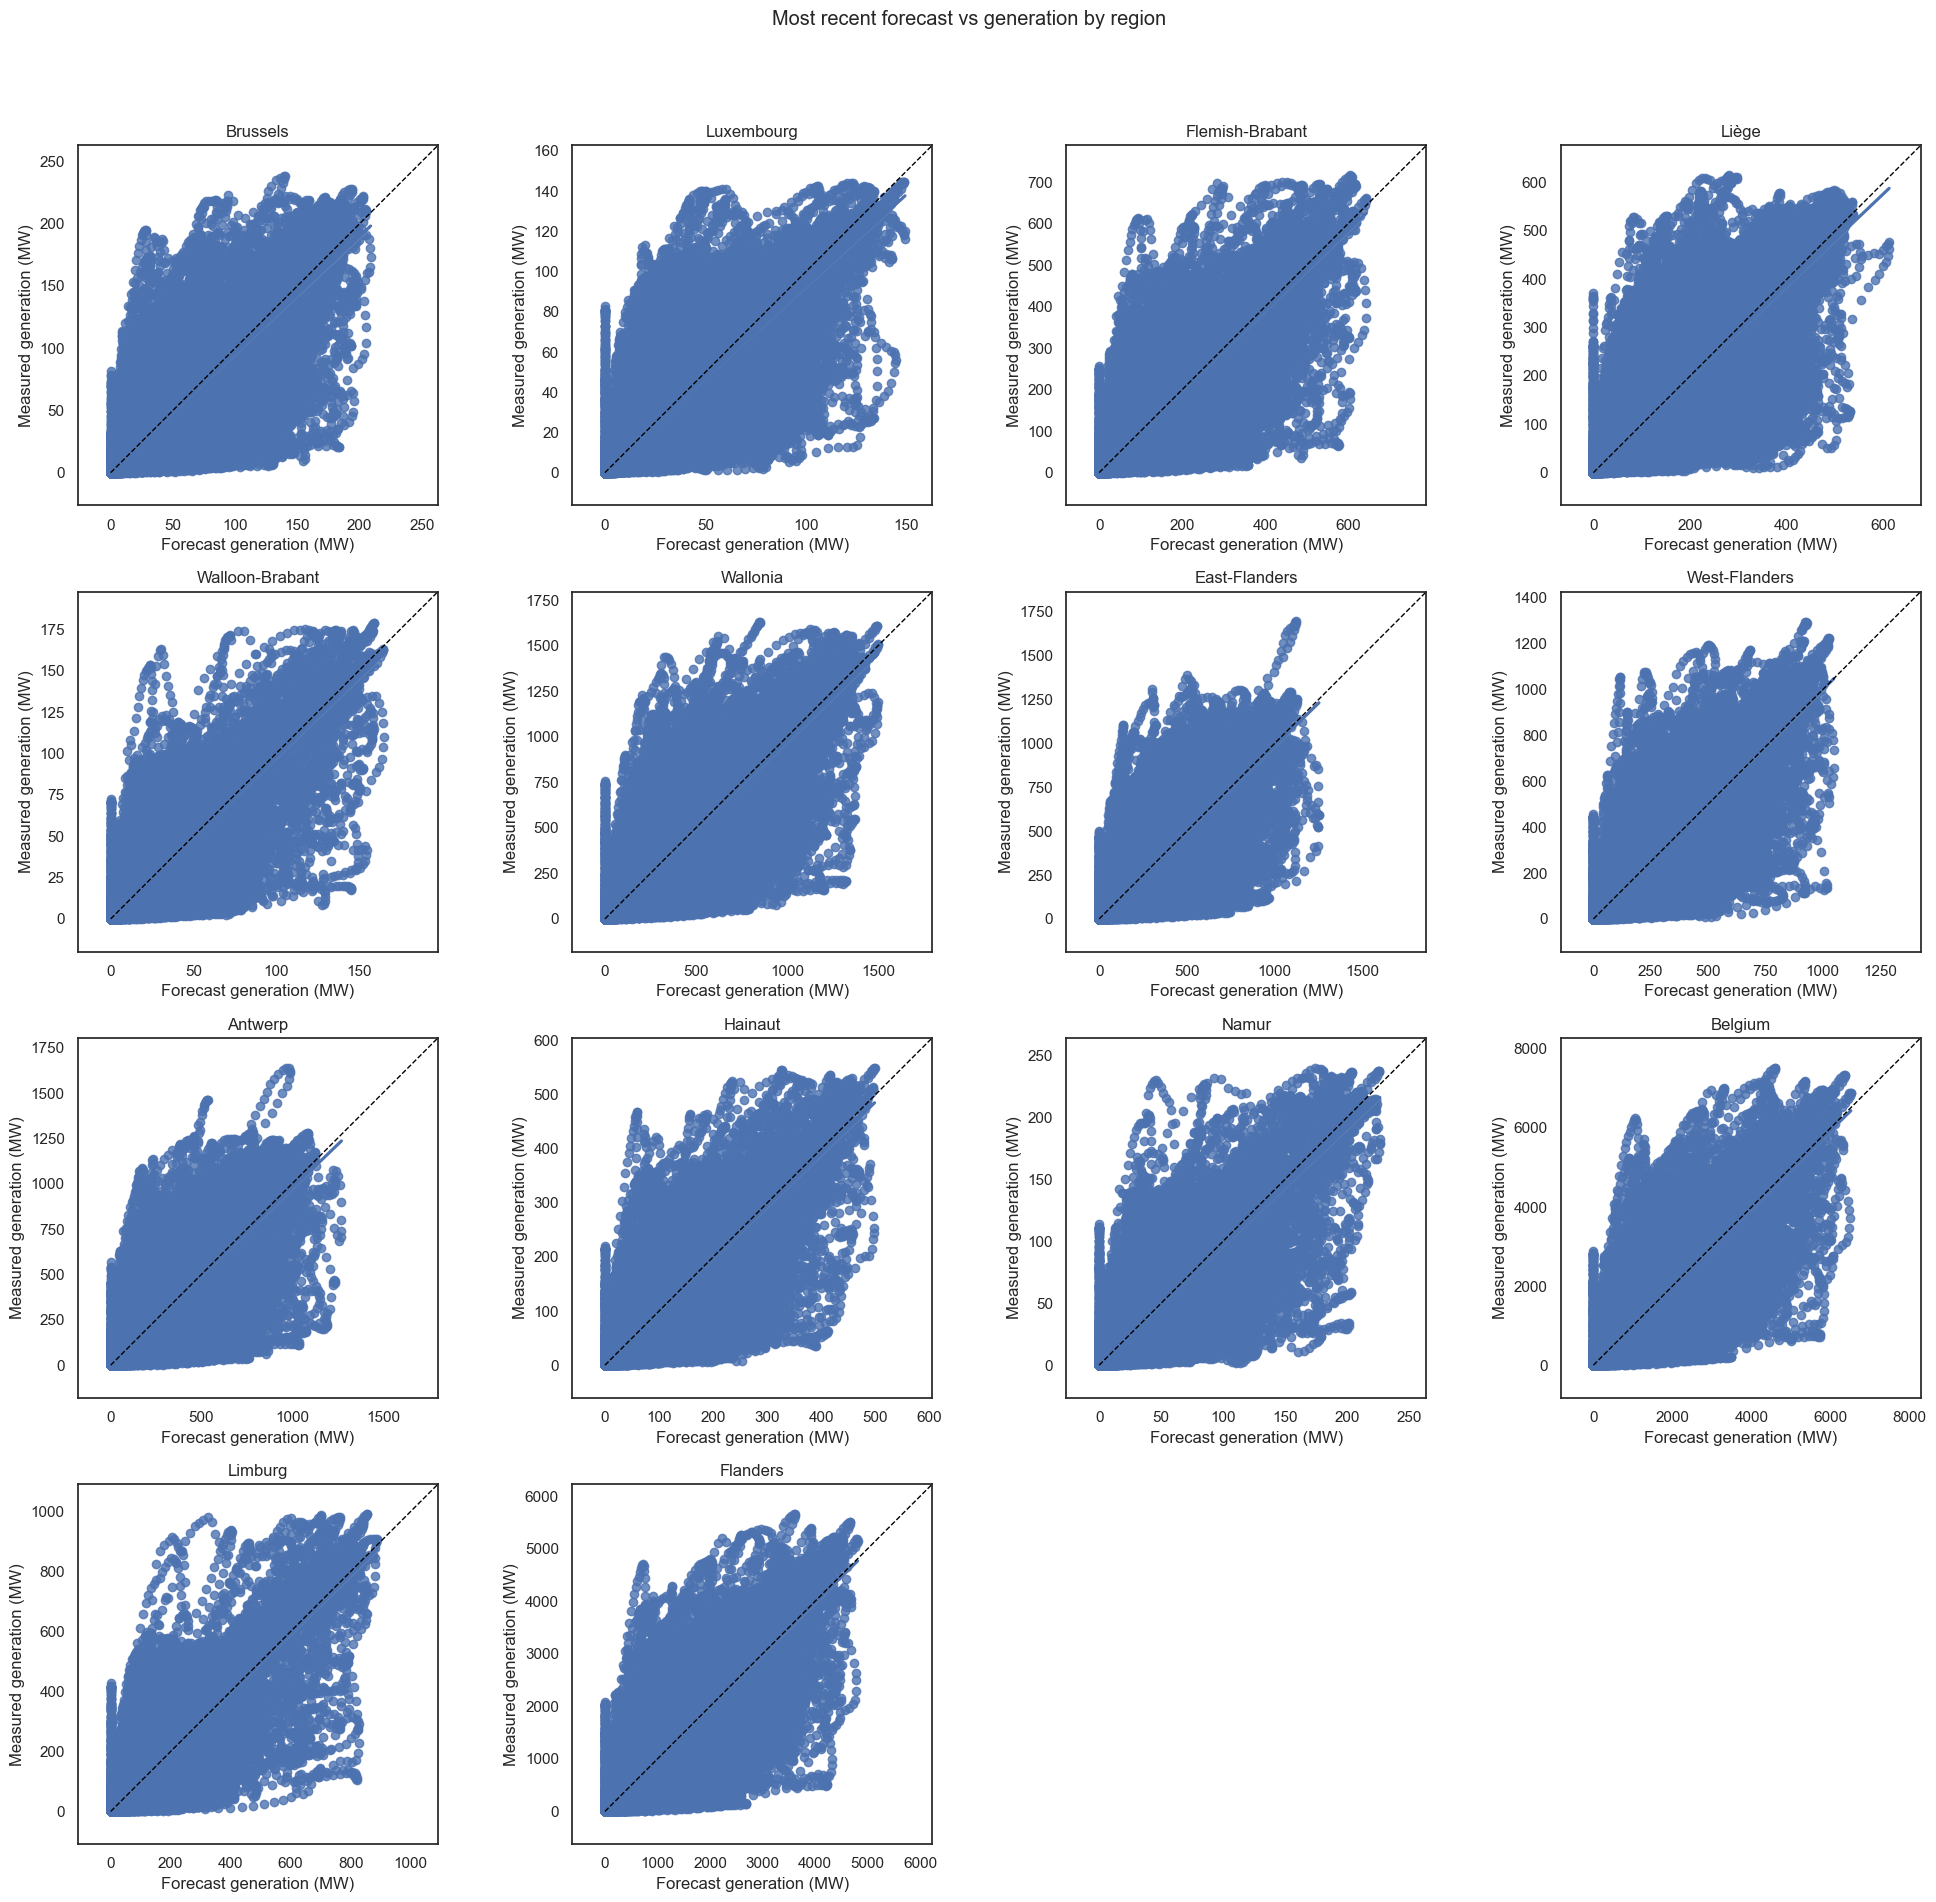

In [86]:
plot_forecast_vs_measured_subplots(df, 'measured', 'forecast_recent', 'Most recent forecast vs generation by region')

In [7]:
df_be[(df_be.measured > 0) & (df_be.forecast_week == 0)].sort_values('measured')

measured  forecast_recent  forecast_day  \
datetime                                                             
2024-05-11 19:30:00+00:00     0.001            0.000         0.000   
2024-05-28 20:30:00+00:00     0.001            0.000         0.000   
2021-07-13 03:30:00+00:00     0.001            0.000         0.000   
2022-08-28 18:45:00+00:00     0.001            0.000         0.000   
2022-08-27 18:45:00+00:00     0.001            0.000         0.000   
...                             ...              ...           ...   
2021-04-01 12:45:00+00:00  2805.278         2819.435      2993.268   
2021-04-01 13:00:00+00:00  2808.270         2768.048      2937.239   
2021-04-01 12:15:00+00:00  2822.197         2886.976      3064.942   
2021-04-01 12:00:00+00:00  2825.932         2893.899      3071.109   
2021-09-23 11:30:00+00:00  2879.877         2621.654      2658.755   

                           forecast_week  
datetime                                  
2024-05-11 19:30:00+00:00            0.0  
2024-05-28 20:30:00+00:00            0.0  
2021-07-13 03:30:00+00:00            0.0  
2022-08-28 18:45:00+00:00            0.0  
2022-08-27 18:45:00+00:00            0.0  
...                                  ...  
2021-04-01 12:45:00+00:00            0.0  
2021-04-01 13:00:00+00:00            0.0  
2021-04-01 12:15:00+00:00            0.0  
2021-04-01 12:00:00+00:00            0.0  
2021-09-23 11:30:00+00:00            0.0  

[2526 rows x 4 columns]

## Errors

In [28]:
df_stats_by_region_week = pd.DataFrame()

for region in df.region.unique():
    region_data = df[df.region == region]
    stats = preds_vs_actual_stats(region_data.measured, region_data.forecast_week)
    stats_formatted = [f"{x:.2f}" if abs(x) >= 0.01 else f"{x:.2g}" if x is not None else "NaN" for x in stats]
    region_df = pd.DataFrame(stats_formatted, columns=[region])
    if df_stats_by_region_week.empty:
        df_stats_by_region_week = region_df
    else:
        df_stats_by_region_week = pd.concat([df_stats_by_region_week, region_df], axis=1)

df_stats_by_region_week.index = [
    "Mean (Actual)", "Median (Actual)", "Mode (Actual)", "Std Dev (Actual)",
    "Mean (Predicted)", "Median (Predicted)", "Mode (Predicted)", "Std Dev (Predicted)",
    "Mean Error", "Median Error", "Mode Error", "Std Dev Error", "Min Error", "Max Error",
    "Mean Error (%)", "Min Error (%)", "Max Error (%)", "Mean Absolute Error (%)", "MAE", "MedAE", "MSE", "RMSE",
    "MAPE", "SMAPE", "Mean Bias Deviation (%)", "R² Score", "Correlation Coefficient", "Theil's U"
]

display(df_stats_by_region_week.T)

Mean (Actual) Median (Actual) Mode (Actual) Std Dev (Actual)  \
Brussels                14.75            0.02             0            31.18   
Luxembourg              14.98            0.03             0            24.88   
Flemish-Brabant         57.84            0.12             0           101.56   
Liège                   60.78            0.13             0           103.35   
Walloon-Brabant         14.07            0.03             0            24.16   
Wallonia               156.40            0.53             0           262.93   
East-Flanders          117.73            0.26             0           208.07   
West-Flanders          106.32            0.24             0           184.87   
Antwerp                115.88            0.23             0           204.90   
Hainaut                 45.69            0.13             0            79.47   
Namur                   20.89            0.04             0            35.29   
Belgium                646.47            2.29             0          1108.59   
Limburg                 77.54            0.16             0           132.55   
Flanders               475.32            1.54             0           819.64   

                Mean (Predicted) Median (Predicted) Mode (Predicted)  \
Brussels                   14.08               0.09                0   
Luxembourg                 14.81               0.14                0   
Flemish-Brabant            54.56               0.50                0   
Liège                      57.71               0.55                0   
Walloon-Brabant            13.26               0.13                0   
Wallonia                  149.09               1.47                0   
East-Flanders             110.31               1.00                0   
West-Flanders              98.66               0.93                0   
Antwerp                   109.36               0.99                0   
Hainaut                    43.28               0.40                0   
Namur                      20.04               0.19                0   
Belgium                   609.10               5.91                0   
Limburg                    73.05               0.72                0   
Flanders                  445.93               4.29                0   

                Std Dev (Predicted) Mean Error Median Error Mode Error  \
Brussels                      29.10       0.68            0          0   
Luxembourg                    24.11       0.17            0          0   
Flemish-Brabant               92.66       3.29            0          0   
Liège                         95.27       3.07            0          0   
Walloon-Brabant               22.08       0.82            0          0   
Wallonia                     244.41       7.31            0          0   
East-Flanders                187.73       7.42            0          0   
West-Flanders                164.43       7.66            0          0   
Antwerp                      185.75       6.52            0          0   
Hainaut                       72.97       2.41            0          0   
Namur                         32.86       0.85            0          0   
Belgium                     1010.08      37.37            0          0   
Limburg                      119.75       4.49            0          0   
Flanders                     741.29      29.38            0          0   

                Std Dev Error Min Error Max Error Mean Error (%)  \
Brussels                14.97   -162.82    167.68         -76.82   
Luxembourg              11.81   -111.97     94.44         -57.75   
Flemish-Brabant         48.67   -511.64    519.72         -90.11   
Liège                   49.79   -439.64    447.53         -74.31   
Walloon-Brabant         11.53   -127.47    132.71         -58.60   
Wallonia               118.68  -1120.72   1115.87         -62.25   
East-Flanders           98.95   -901.88   1005.73        -108.18   
West-Flanders           87.29   -883.08    940.91        -120.00   
Antwerp    

In [29]:
df_stats_by_region_recent = pd.DataFrame()

for region in df.region.unique():
    region_data = df[df.region == region]
    stats = preds_vs_actual_stats(region_data.measured, region_data.forecast_recent)
    stats_formatted = [f"{x:.2f}" if abs(x) >= 0.01 else f"{x:.2g}" if x is not None else "NaN" for x in stats]
    region_df = pd.DataFrame(stats_formatted, columns=[region])
    if df_stats_by_region_recent.empty:
        df_stats_by_region_recent = region_df
    else:
        df_stats_by_region_recent = pd.concat([df_stats_by_region_recent, region_df], axis=1)

df_stats_by_region_recent.index = [
    "Mean (Actual)", "Median (Actual)", "Mode (Actual)", "Std Dev (Actual)",
    "Mean (Predicted)", "Median (Predicted)", "Mode (Predicted)", "Std Dev (Predicted)",
    "Mean Error", "Median Error", "Mode Error", "Std Dev Error", "Min Error", "Max Error",
    "Mean Error (%)", "Min Error (%)", "Max Error (%)", "Mean Absolute Error (%)", "MAE", "MedAE", "MSE", "RMSE",
    "MAPE", "SMAPE", "Mean Bias Deviation (%)", "R² Score", "Correlation Coefficient", "Theil's U"
]

display(df_stats_by_region_recent.T)

Mean (Actual) Median (Actual) Mode (Actual) Std Dev (Actual)  \
Brussels                14.75            0.02             0            31.18   
Luxembourg              14.98            0.03             0            24.88   
Flemish-Brabant         57.84            0.12             0           101.56   
Liège                   60.78            0.13             0           103.35   
Walloon-Brabant         14.07            0.03             0            24.16   
Wallonia               156.40            0.53             0           262.93   
East-Flanders          117.73            0.26             0           208.07   
West-Flanders          106.32            0.24             0           184.87   
Antwerp                115.88            0.23             0           204.90   
Hainaut                 45.69            0.13             0            79.47   
Namur                   20.89            0.04             0            35.29   
Belgium                646.47            2.29             0          1108.59   
Limburg                 77.54            0.16             0           132.55   
Flanders               475.32            1.54             0           819.64   

                Mean (Predicted) Median (Predicted) Mode (Predicted)  \
Brussels                   14.62               0.11                0   
Luxembourg                 15.42               0.17                0   
Flemish-Brabant            57.35               0.60                0   
Liège                      60.91               0.66                0   
Walloon-Brabant            13.95               0.15                0   
Wallonia                  156.77               1.74                0   
East-Flanders             115.99               1.20                0   
West-Flanders             103.76               1.09                0   
Antwerp                   115.22               1.18                0   
Hainaut                    45.45               0.48                0   
Namur                      21.04               0.23                0   
Belgium                   641.21               7.09                0   
Limburg                    77.50               0.84                0   
Flanders                  469.82               5.09                0   

                Std Dev (Predicted) Mean Error Median Error Mode Error  \
Brussels                      30.54       0.13            0          0   
Luxembourg                    25.40      -0.44            0          0   
Flemish-Brabant               99.19       0.49            0          0   
Liège                        102.67      -0.13            0          0   
Walloon-Brabant               23.68       0.12            0          0   
Wallonia                     261.55      -0.37            0          0   
East-Flanders                201.72       1.75            0          0   
West-Flanders                177.21       2.57            0          0   
Antwerp                      199.98       0.65            0          0   
Hainaut                       78.18       0.24            0          0   
Namur                         35.16      -0.15            0          0   
Belgium                     1085.04       5.27            0          0   
Limburg                      130.16       0.04            0          0   
Flanders                     797.90       5.50            0          0   

                Std Dev Error Min Error Max Error Mean Error (%)  \
Brussels                 5.04    -81.95     79.61         -32.29   
Luxembourg               4.77    -53.02     55.62         -29.38   
Flemish-Brabant         15.79   -182.92    242.31         -45.22   
Liège                   17.99   -229.32    244.99         -34.41   
Walloon-Brabant          3.95    -52.94     69.31         -24.38   
Wallonia                34.40   -429.37    552.94         -27.65   
East-Flanders           33.04   -509.49    447.87         -66.26   
West-Flanders           33.55   -505.04    454.18         -73.03   
Antwerp    

In [30]:
df_stats_by_year_week = pd.DataFrame()

df_fullyears_withyear = df_fullyears.copy()
df_fullyears_withyear['year'] = df_fullyears_withyear.index.year

for year in df_fullyears_withyear.year.unique():
    year_data = df_fullyears_withyear[df_fullyears_withyear.year == year]
    stats = preds_vs_actual_stats(year_data.measured, year_data.forecast_week)
    stats_formatted = [f"{x:.2f}" if abs(x) >= 0.01 else f"{x:.2g}" if x is not None else "NaN" for x in stats]
    year_df = pd.DataFrame(stats_formatted, columns=[year])
    if df_stats_by_year_week.empty:
        df_stats_by_year_week = year_df
    else:
        df_stats_by_year_week = pd.concat([df_stats_by_year_week, year_df], axis=1)

df_stats_by_year_week.index = [
    "Mean (Actual)", "Median (Actual)", "Mode (Actual)", "Std Dev (Actual)",
    "Mean (Predicted)", "Median (Predicted)", "Mode (Predicted)", "Std Dev (Predicted)",
    "Mean Error", "Median Error", "Mode Error", "Std Dev Error", "Min Error", "Max Error",
    "Mean Error (%)", "Min Error (%)", "Max Error (%)", "Mean Absolute Error (%)", "MAE", "MedAE", "MSE", "RMSE",
    "MAPE", "SMAPE", "Mean Bias Deviation (%)", "R² Score", "Correlation Coefficient", "Theil's U"
]

display(df_stats_by_year_week)

2019         2020        2021        2022  \
Mean (Actual)                  85.90       103.39      114.00      155.97   
Median (Actual)                 0.09         0.18        0.25        0.17   
Mode (Actual)                      0            0           0           0   
Std Dev (Actual)              248.33       307.63      333.94      452.06   
Mean (Predicted)               81.28       100.05      101.92      138.47   
Median (Predicted)              0.38         0.51        0.04        0.62   
Mode (Predicted)                   0            0           0           0   
Std Dev (Predicted)           225.82       284.51      281.18      392.23   
Mean Error                      4.62         3.33       12.08       17.50   
Median Error                       0            0           0           0   
Mode Error                         0            0           0           0   
Std Dev Error                  93.90       113.80      140.28      176.89   
Min Error                   -1551.23     -1944.22    -1931.35    -2439.19   
Max Error                    2127.08      2106.31     2879.88     3365.02   
Mean Error (%)                -76.36       -78.17      -73.84      -58.87   
Min Error (%)            -2345400.00  -1096100.00  -535100.00  -445000.00   
Max Error (%)                 100.00       100.00      100.00      100.00   
Mean Absolute Error (%)        91.29        92.61       93.94       78.82   
MAE                            28.06        32.92       42.19       52.71   
MedAE                           0.16         0.16        0.18        0.21   
MSE                          8838.49     12960.53    19823.45    31596.22   
RMSE                           94.01       113.84      140.80      177.75   
MAPE                           91.29        92.61       93.94       78.82   
SMAPE                          50.31        49.15       55.50       51.62   
Mean Bias Deviation (%)         5.38         3.22       10.60       11.22   
R² Score                        0.86         0.86        0.82        0.85   
Correlation Coefficient         0.93         0.93        0.91        0.92   
Theil's U                       0.31         0.30        0.34        0.32   

                                2023  
Mean (Actual)                 174.07  
Median (Actual)                 0.13  
Mode (Actual)                      0  
Std Dev (Actual)              523.63  
Mean (Predicted)              168.06  
Median (Predicted)              0.74  
Mode (Predicted)                   0  
Std Dev (Predicted)           485.26  
Mean Error                      6.01  
Median Error                       0  
Mode Error                         0  
Std Dev Error                 227.08  
Min Error                   -3638.97  
Max Error                    4349.58  
Mean Error (%)               -144.93  
Min Error (%)            -3427500.00  
Max Error (%)                 100.00  
Mean Absolute Error (%)       163.56  
MAE                            66.74  
MedAE                           0.29  
MSE                         51603.34  
RMSE                          227.16  
MAPE                          163.56  
SMAPE                          58.23  
Mean Bias Deviation (%)         3.45  
R² Score                        0.81  
Correlation Coefficient         0.90  
Theil's U                       0.35

In [31]:
df_stats_by_year_recent = pd.DataFrame()

df_fullyears_withyear = df_fullyears.copy()
df_fullyears_withyear['year'] = df_fullyears_withyear.index.year

for year in df_fullyears_withyear.year.unique():
    year_data = df_fullyears_withyear[df_fullyears_withyear.year == year]
    stats = preds_vs_actual_stats(year_data.measured, year_data.forecast_recent)
    stats_formatted = [f"{x:.2f}" if abs(x) >= 0.01 else f"{x:.2g}" if x is not None else "NaN" for x in stats]
    year_df = pd.DataFrame(stats_formatted, columns=[year])
    if df_stats_by_year_recent.empty:
        df_stats_by_year_recent = year_df
    else:
        df_stats_by_year_recent = pd.concat([df_stats_by_year_recent, year_df], axis=1)

df_stats_by_year_recent.index = [
    "Mean (Actual)", "Median (Actual)", "Mode (Actual)", "Std Dev (Actual)",
    "Mean (Predicted)", "Median (Predicted)", "Mode (Predicted)", "Std Dev (Predicted)",
    "Mean Error", "Median Error", "Mode Error", "Std Dev Error", "Min Error", "Max Error",
    "Mean Error (%)", "Min Error (%)", "Max Error (%)", "Mean Absolute Error (%)", "MAE", "MedAE", "MSE", "RMSE",
    "MAPE", "SMAPE", "Mean Bias Deviation (%)", "R² Score", "Correlation Coefficient", "Theil's U"
]

display(df_stats_by_year_recent)

2019        2020        2021        2022  \
Mean (Actual)                 85.90      103.39      114.00      155.97   
Median (Actual)                0.09        0.18        0.25        0.17   
Mode (Actual)                     0           0           0           0   
Std Dev (Actual)             248.33      307.63      333.94      452.06   
Mean (Predicted)              86.55      103.26      113.00      155.29   
Median (Predicted)             0.46        0.44        0.33        0.71   
Mode (Predicted)                  0           0           0           0   
Std Dev (Predicted)          248.63      306.08      326.96      448.14   
Mean Error                    -0.65        0.13        0.99        0.68   
Median Error                      0           0           0           0   
Mode Error                        0           0           0           0   
Std Dev Error                 34.66       39.49       47.30       49.68   
Min Error                   -954.48    -1033.92    -1240.84    -1553.11   
Max Error                    783.65     1029.23     1297.49     1890.21   
Mean Error (%)               -44.59      -34.63      -34.56      -38.59   
Min Error (%)            -440800.00  -236300.00  -870900.00  -434000.00   
Max Error (%)                100.00      100.00      100.00      100.00   
Mean Absolute Error (%)       52.09       43.28       44.96       46.77   
MAE                           10.84       11.98       14.21       14.84   
MedAE                          0.10        0.10        0.12        0.14   
MSE                         1201.81     1559.49     2238.75     2468.41   
RMSE                          34.67       39.49       47.32       49.68   
MAPE                          52.09       43.28       44.96       46.77   
SMAPE                         30.67       29.35       30.94       26.32   
Mean Bias Deviation (%)       -0.75        0.12        0.87        0.44   
R² Score                       0.98        0.98        0.98        0.99   
Correlation Coefficient        0.99        0.99        0.99        0.99   
Theil's U                      0.11        0.10        0.12        0.09   

                               2023  
Mean (Actual)                174.07  
Median (Actual)                0.13  
Mode (Actual)                     0  
Std Dev (Actual)             523.63  
Mean (Predicted)             172.65  
Median (Predicted)             0.79  
Mode (Predicted)                  0  
Std Dev (Predicted)          515.90  
Mean Error                     1.42  
Median Error                      0  
Mode Error                        0  
Std Dev Error                 58.88  
Min Error                  -1565.72  
Max Error                   2337.12  
Mean Error (%)               -61.40  
Min Error (%)            -661100.00  
Max Error (%)                100.00  
Mean Absolute Error (%)       69.92  
MAE                           17.24  
MedAE                          0.17  
MSE                         3469.31  
RMSE                          58.90  
MAPE                          69.92  
SMAPE                         29.22  
Mean Bias Deviation (%)        0.81  
R² Score                       0.99  
Correlation Coefficient        0.99  
Theil's U                      0.09

In [24]:
df_errs = df[['region','forecast_week','forecast_recent','measured']]
df_errs = df_errs[df_errs.measured != 0]
df_errs = df_errs.dropna()

df_errs['forecast_week_error'] = df_errs.measured - df_errs.forecast_week
df_errs['forecast_week_error_pc'] = np.divide(
    df_errs.forecast_week_error,
    df_errs.measured,
    out=np.zeros_like(df_errs.forecast_week_error),
    where=df_errs.measured != 0
) * 100
df_errs['forecast_week_abs_error_pc'] = np.divide(
    np.abs(df_errs.forecast_week_error),
    df_errs.measured,
    out=np.zeros_like(df_errs.forecast_week_error),
    where=df_errs.measured != 0
) * 100

df_errs['forecast_recent_error'] = df_errs.measured - df_errs.forecast_recent
df_errs['forecast_recent_error_pc'] = np.divide(
    df_errs.forecast_recent_error,
    df_errs.measured,
    out=np.zeros_like(df_errs.forecast_recent_error),
    where=df_errs.measured != 0
) * 100
df_errs['forecast_recent_abs_error_pc'] = np.divide(
    np.abs(df_errs.forecast_recent_error),
    df_errs.measured,
    out=np.zeros_like(df_errs.forecast_recent_error),
    where=df_errs.measured != 0
) * 100

df_errs = df_errs[['region','measured', 'forecast_week', 'forecast_week_error', 'forecast_week_error_pc', 'forecast_week_abs_error_pc', 'forecast_recent', 'forecast_recent_error', 'forecast_recent_error_pc', 'forecast_recent_abs_error_pc']]

In [16]:
pd.options.display.float_format = '{:,.2f}'.format
display(df_errs.describe())
pd.options.display.float_format = None

measured  forecast_week  forecast_week_error  \
count 1,530,969.00   1,530,969.00         1,530,969.00   
mean        267.80         252.29                15.52   
std         571.26         520.84               247.75   
min           0.00           0.00            -4,998.91   
25%          17.42          19.80               -15.57   
50%          71.06          73.51                 0.55   
75%         249.02         237.08                31.27   
max       7,526.47       6,512.31             5,193.69   

       forecast_week_error_pc  forecast_week_abs_error_pc  forecast_recent  \
count            1,530,969.00                1,530,969.00     1,530,969.00   
mean                  -182.08                      216.33           265.61   
std                  5,888.28                    5,887.12           558.82   
min             -3,427,500.00                        0.00             0.00   
25%                    -53.72                       16.24            18.57   
50%                      3.91                       35.21            72.61   
75%                     29.60                       71.51           248.11   
max                    100.00                3,427,500.00         7,055.24   

       forecast_recent_error  forecast_recent_error_pc  \
count           1,530,969.00              1,530,969.00   
mean                    2.19                    -94.22   
std                    72.16                  3,228.63   
min                -1,672.95             -1,188,925.00   
25%                    -8.36                    -19.67   
50%                    -0.26                     -1.16   
75%                     8.02                     10.82   
max                 2,337.12                    100.00   

       forecast_recent_abs_error_pc  
count                  1,530,969.00  
mean                         111.12  
std                        3,228.10  
min                            0.00  
25%                            5.44  
50%                           14.23  
75%                           32.74  
max                    1,188,925.00

In [40]:
region_areas_df = pd.DataFrame({
    "Region": [
        "Brussels", "Walloon-Brabant", "Flemish-Brabant", "Limburg",
        "Antwerp", "East-Flanders", "West-Flanders", "Namur", "Hainaut",
        "Liège", "Luxembourg", "Wallonia", "Belgium", "Flanders"
    ],
    "Area": [
        162, 1097, 2118, 2427, 2876, 3007, 3197, 3675, 3813, 3857, 4459, 16901, 13626, 30689
    ]
})

In [38]:
df_stats_by_region_week.T.reset_index().rename(columns={'index':'Region'})

Region Mean (Actual) Median (Actual) Mode (Actual)  \
0          Brussels         14.75            0.02             0   
1        Luxembourg         14.98            0.03             0   
2   Flemish-Brabant         57.84            0.12             0   
3             Liège         60.78            0.13             0   
4   Walloon-Brabant         14.07            0.03             0   
5          Wallonia        156.40            0.53             0   
6     East-Flanders        117.73            0.26             0   
7     West-Flanders        106.32            0.24             0   
8           Antwerp        115.88            0.23             0   
9           Hainaut         45.69            0.13             0   
10            Namur         20.89            0.04             0   
11          Belgium        646.47            2.29             0   
12          Limburg         77.54            0.16             0   
13         Flanders        475.32            1.54             0   

   Std Dev (Actual) Mean (Predicted) Median (Predicted) Mode (Predicted)  \
0             31.18            14.08               0.09                0   
1             24.88            14.81               0.14                0   
2            101.56            54.56               0.50                0   
3            103.35            57.71               0.55                0   
4             24.16            13.26               0.13                0   
5            262.93           149.09               1.47                0   
6            208.07           110.31               1.00                0   
7            184.87            98.66               0.93                0   
8            204.90           109.36               0.99                0   
9             79.47            43.28               0.40                0   
10            35.29            20.04               0.19                0   
11          1108.59           609.10               5.91                0   
12           132.55            73.05               0.72                0   
13           819.64           445.93               4.29                0   

   Std Dev (Predicted) Mean Error Median Error Mode Error Std Dev Error  \
0                29.10       0.68            0          0         14.97   
1                24.11       0.17            0          0         11.81   
2                92.66       3.29            0          0         48.67   
3                95.27       3.07            0          0         49.79   
4                22.08       0.82            0          0         11.53   
5               244.41       7.31            0          0        118.68   
6               187.73       7.42            0          0         98.95   
7               164.43       7.66            0          0         87.29   
8               185.75       6.52            0          0         99.96   
9                72.97       2.41            0          0         36.89   
10               32.86       0.85            0          0         16.85   
11             1010.08      37.37            0          0        497.85   
12              119.75       4.49            0          0         62.35   
13              741.29      29.38            0          0        374.33   

   Min Error Max Error Mean Error (%) Min Error (%) Max Error (%)  \
0    -162.82    167.68         -76.82    -325600.00        100.00   
1    -111.97     94.44         -57.75    -107400.00        100.00   
2    -511.64    519.72         -90.11    -446400.00        100.00   
3    -439.64    447.53         -74.31    -286100.00        100.00   
4    -127.47    132.71         -58.60    -102080.00        100.00   
5   -1120.72   1115.87         -62.25    -504100.00        100.00   
6    -901.88   1005.73        -108.18    -783700.00        100.00   
7    -883.08    940.91        -120.00   -2345400.00        100.00   
8    -977.54    933.43        -123.92   -3427500.00        100.00   
9    -353.54    408.82         -83.69    -247800.0

In [44]:
pd.merge(region_areas_df, df_stats_by_region_week.T.reset_index().rename(columns={'index':'Region'}), on="Region", how="outer").sort_values(by="Area", ascending=True)

Region   Area Mean (Actual) Median (Actual) Mode (Actual)  \
2          Brussels    162         14.75            0.02             0   
12  Walloon-Brabant   1097         14.07            0.03             0   
5   Flemish-Brabant   2118         57.84            0.12             0   
7           Limburg   2427         77.54            0.16             0   
0           Antwerp   2876        115.88            0.23             0   
3     East-Flanders   3007        117.73            0.26             0   
13    West-Flanders   3197        106.32            0.24             0   
10            Namur   3675         20.89            0.04             0   
6           Hainaut   3813         45.69            0.13             0   
8             Liège   3857         60.78            0.13             0   
9        Luxembourg   4459         14.98            0.03             0   
1           Belgium  13626        646.47            2.29             0   
11         Wallonia  16901        156.40            0.53             0   
4          Flanders  30689        475.32            1.54             0   

   Std Dev (Actual) Mean (Predicted) Median (Predicted) Mode (Predicted)  \
2             31.18            14.08               0.09                0   
12            24.16            13.26               0.13                0   
5            101.56            54.56               0.50                0   
7            132.55            73.05               0.72                0   
0            204.90           109.36               0.99                0   
3            208.07           110.31               1.00                0   
13           184.87            98.66               0.93                0   
10            35.29            20.04               0.19                0   
6             79.47            43.28               0.40                0   
8            103.35            57.71               0.55                0   
9             24.88            14.81               0.14                0   
1           1108.59           609.10               5.91                0   
11           262.93           149.09               1.47                0   
4            819.64           445.93               4.29                0   

   Std Dev (Predicted) Mean Error Median Error Mode Error Std Dev Error  \
2                29.10       0.68            0          0         14.97   
12               22.08       0.82            0          0         11.53   
5                92.66       3.29            0          0         48.67   
7               119.75       4.49            0          0         62.35   
0               185.75       6.52            0          0         99.96   
3               187.73       7.42            0          0         98.95   
13              164.43       7.66            0          0         87.29   
10               32.86       0.85            0          0         16.85   
6                72.97       2.41            0          0         36.89   
8                95.27       3.07            0          0         49.79   
9                24.11       0.17            0          0         11.81   
1              1010.08      37.37            0          0        497.85   
11              244.41       7.31            0          0        118.68   
4               741.29      29.38            0          0        374.33   

   Min Error Max Error Mean Error (%) Min Error (%) Max Error (%)  \
2    -162.82    167.68         -76.82    -325600.00        100.00   
12   -127.47    132.71         -58.60    -102080.00        100.00   
5    -511.64    519.72         -90.11    -446400.00        100.00   
7    -716.08    709.79         -88.52    -463450.00        100.00   
0    -977.54    933.43        -123.92   -3427500.00        100.00   
3    -901.88   1005.73        -108.18    -783700.00        100.00   
13   -883.08    940.91        -120.00   -2345400.00        100.00   
10   -170.86    185.19         -75.55    -344800.00        100.00   
6    -353.54  

In [45]:
pd.merge(region_areas_df, df_stats_by_region_week.T.reset_index().rename(columns={'index':'Region'}), on="Region", how="outer").sort_values(by="Area", ascending=True)

Region   Area Mean (Actual) Median (Actual) Mode (Actual)  \
2          Brussels    162         14.75            0.02             0   
12  Walloon-Brabant   1097         14.07            0.03             0   
5   Flemish-Brabant   2118         57.84            0.12             0   
7           Limburg   2427         77.54            0.16             0   
0           Antwerp   2876        115.88            0.23             0   
3     East-Flanders   3007        117.73            0.26             0   
13    West-Flanders   3197        106.32            0.24             0   
10            Namur   3675         20.89            0.04             0   
6           Hainaut   3813         45.69            0.13             0   
8             Liège   3857         60.78            0.13             0   
9        Luxembourg   4459         14.98            0.03             0   
1           Belgium  13626        646.47            2.29             0   
11         Wallonia  16901        156.40            0.53             0   
4          Flanders  30689        475.32            1.54             0   

   Std Dev (Actual) Mean (Predicted) Median (Predicted) Mode (Predicted)  \
2             31.18            14.08               0.09                0   
12            24.16            13.26               0.13                0   
5            101.56            54.56               0.50                0   
7            132.55            73.05               0.72                0   
0            204.90           109.36               0.99                0   
3            208.07           110.31               1.00                0   
13           184.87            98.66               0.93                0   
10            35.29            20.04               0.19                0   
6             79.47            43.28               0.40                0   
8            103.35            57.71               0.55                0   
9             24.88            14.81               0.14                0   
1           1108.59           609.10               5.91                0   
11           262.93           149.09               1.47                0   
4            819.64           445.93               4.29                0   

   Std Dev (Predicted) Mean Error Median Error Mode Error Std Dev Error  \
2                29.10       0.68            0          0         14.97   
12               22.08       0.82            0          0         11.53   
5                92.66       3.29            0          0         48.67   
7               119.75       4.49            0          0         62.35   
0               185.75       6.52            0          0         99.96   
3               187.73       7.42            0          0         98.95   
13              164.43       7.66            0          0         87.29   
10               32.86       0.85            0          0         16.85   
6                72.97       2.41            0          0         36.89   
8                95.27       3.07            0          0         49.79   
9                24.11       0.17            0          0         11.81   
1              1010.08      37.37            0          0        497.85   
11              244.41       7.31            0          0        118.68   
4               741.29      29.38            0          0        374.33   

   Min Error Max Error Mean Error (%) Min Error (%) Max Error (%)  \
2    -162.82    167.68         -76.82    -325600.00        100.00   
12   -127.47    132.71         -58.60    -102080.00        100.00   
5    -511.64    519.72         -90.11    -446400.00        100.00   
7    -716.08    709.79         -88.52    -463450.00        100.00   
0    -977.54    933.43        -123.92   -3427500.00        100.00   
3    -901.88   1005.73        -108.18    -783700.00        100.00   
13   -883.08    940.91        -120.00   -2345400.00        100.00   
10   -170.86    185.19         -75.55    -344800.00        100.00   
6    -353.54  

In [16]:
total_non_zero = df_errs.measured[df_errs.measured != 0].count()
print(f'Total non-zero data\t\t\t{total_non_zero:,}')
print(f'Week forecast positive errors:\t\t{(df_errs.forecast_week_error_pc[df_errs.forecast_week_error_pc > 0].count())/total_non_zero*100:.2f}%')
print(f'Week forecast negative errors:\t\t{(df_errs.forecast_week_error_pc[df_errs.forecast_week_error_pc < 0].count())/total_non_zero*100:.2f}%')
print(f'Recent forecast positive errors:\t{(df_errs.forecast_recent_error_pc[df_errs.forecast_recent_error_pc > 0].count())/total_non_zero*100:.2f}%')
print(f'Recent forecast negative errors:\t{(df_errs.forecast_recent_error_pc[df_errs.forecast_recent_error_pc < 0].count())/total_non_zero*100:.2f}%')

Total non-zero data			1,530,969
Week forecast positive errors:		53.26%
Week forecast negative errors:		46.73%
Recent forecast positive errors:	46.99%
Recent forecast negative errors:	52.94%


In [17]:
total_zero_or_nan = df_errs.forecast_recent_error_pc.isna().sum() + (df_errs.forecast_recent_error_pc == 0).sum()
print(f'Total zero or NaN in recent errors:\t{total_zero_or_nan}')

Total zero or NaN in recent errors:	975


### Plots

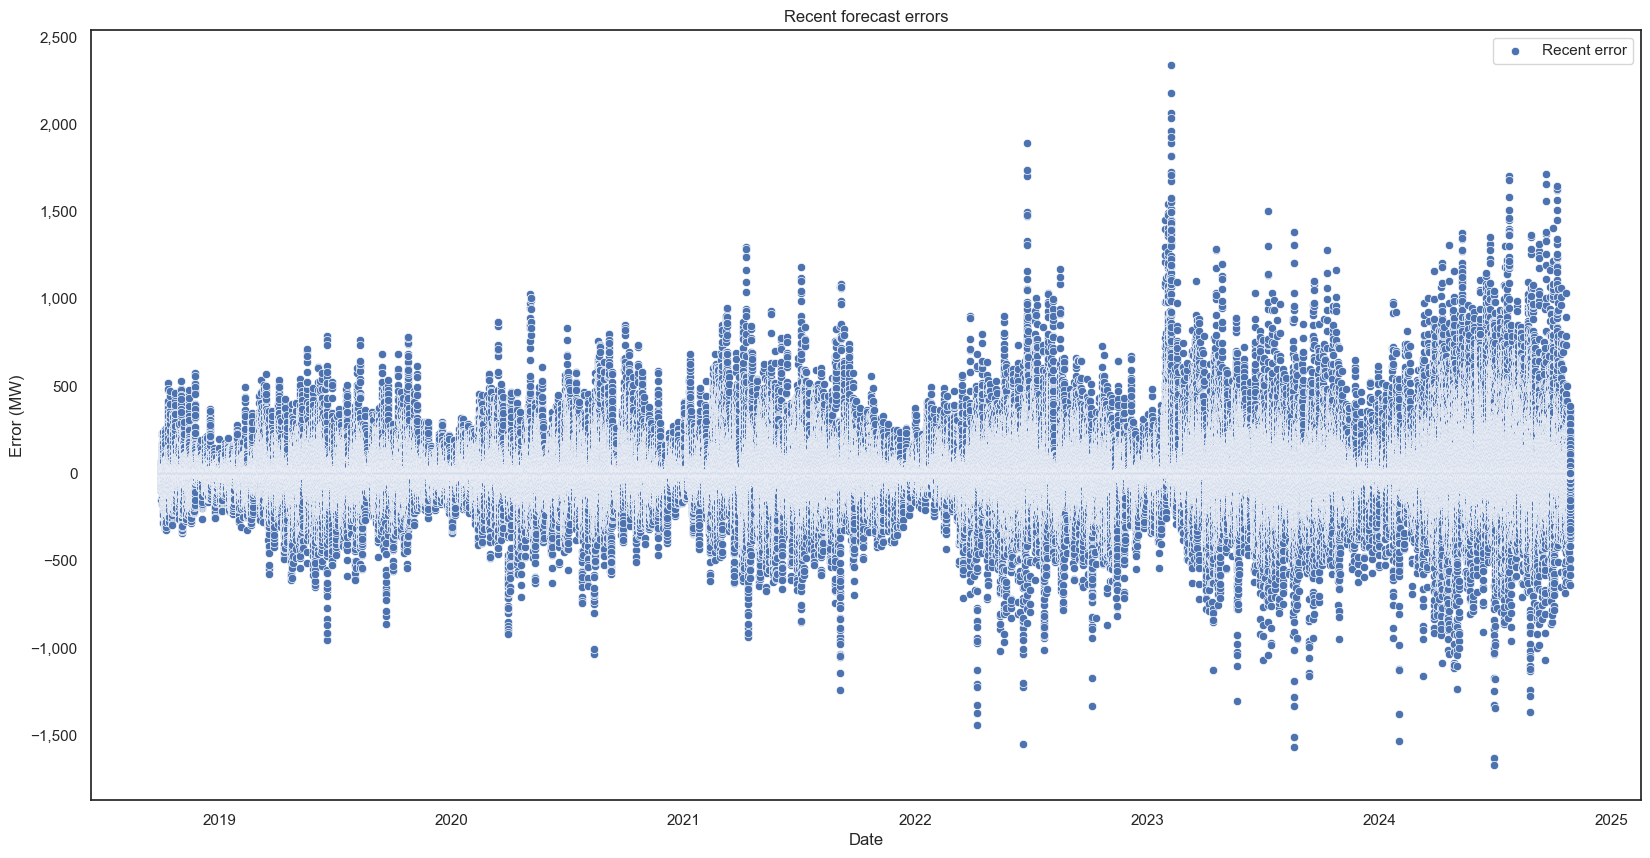

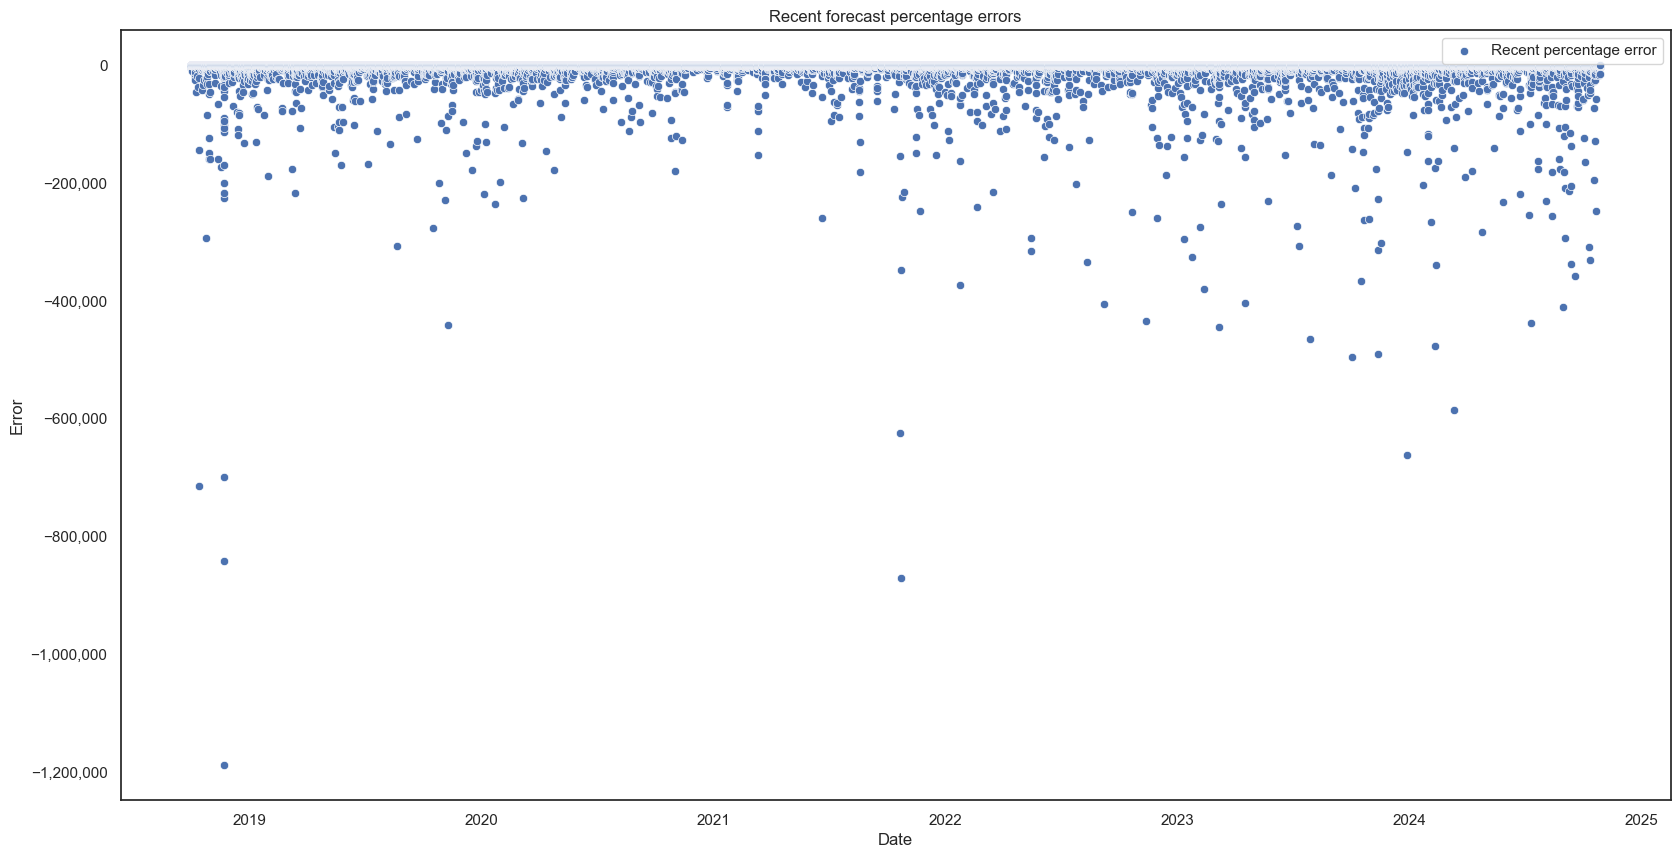

In [149]:
plt.figure(figsize=(20,10))
plt.title('Recent forecast errors')
sns.scatterplot(data=df_errs, x='datetime', y='forecast_recent_error', label='Recent error')
plt.ylabel('Error (MW)')
plt.xlabel('Date')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(20,10))
plt.title('Recent forecast percentage errors')
sns.scatterplot(data=df_errs, x='datetime', y='forecast_recent_error_pc', label='Recent percentage error')
plt.ylabel('Error')
plt.xlabel('Date')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend(loc='upper right')
plt.show()

In [8]:
def plot_forecast_errors_vs_measured(df, col_y, title):
    region_max = df_errs.groupby('region').measured.max().sort_values(ascending=False)
    plt.figure(figsize=(20, 10))
    plt.title(title)
    for region in region_max.index.values:
        ax = sns.scatterplot(data=df_errs, x='datetime', y=col_y, label=region, size=1)
    plt.ylabel('Error (MW)')
    plt.xlabel('Date')
    plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
plot_forecast_errors_vs_measured(df_errs, 'forecast_recent_error', 'Most recent forecast errors')

In [ ]:
plot_forecast_errors_vs_measured(df_errs, 'forecast_week_error', 'Week forecast errors')

Recent forecast error statistics
Mean:		265
Median:		72
Std dev:	558
IQR:		229
MAD:		98


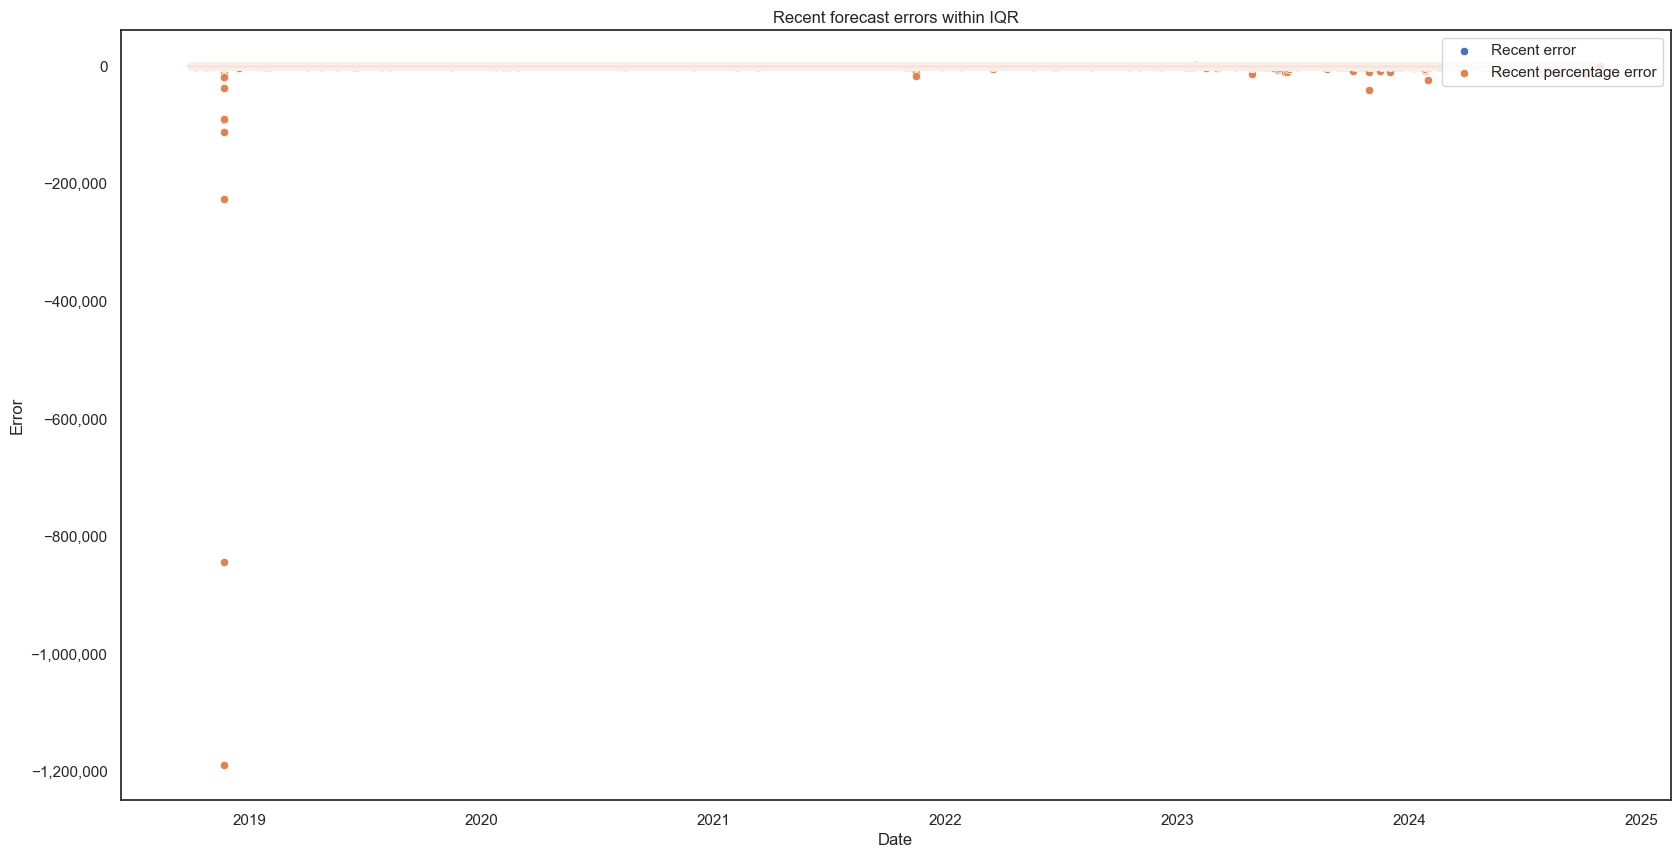

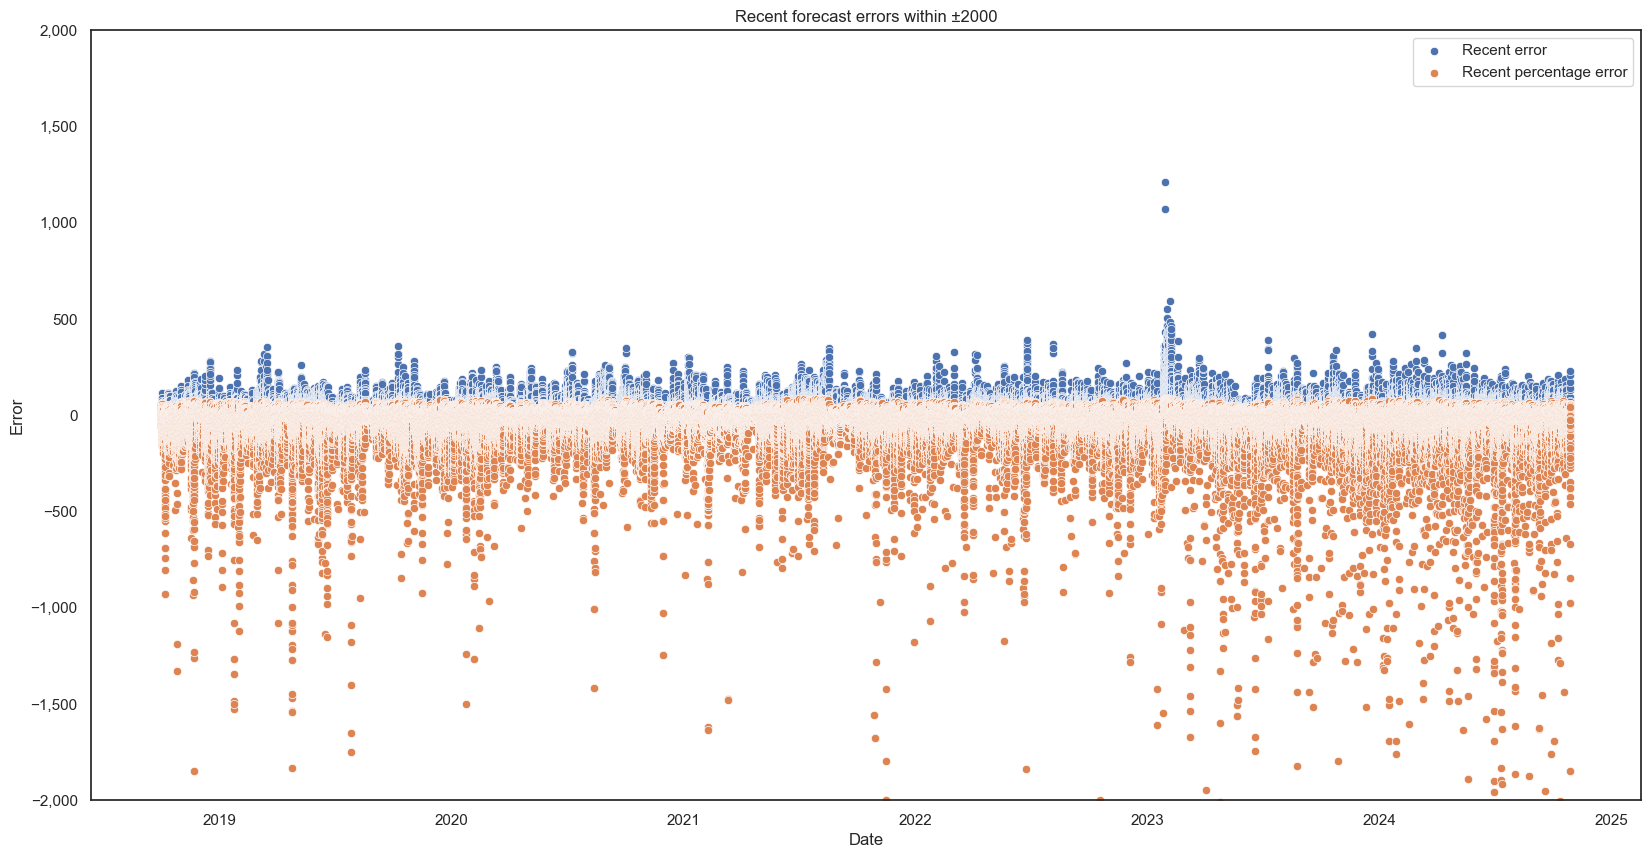

In [27]:
# print('Recent forecast error statistics')
# stats_errs = df_errs.forecast_recent.agg(['mean', 'median', 'std'])
# print(f"Mean:\t\t{int(stats_errs.get('mean'))}")
# print(f"Median:\t\t{int(stats_errs.get('median'))}")
# print(f"Std dev:\t{int(stats_errs.get('std'))}")
# print(f"IQR:\t\t{int(q3-q1)}")
# print(f"MAD:\t\t{int(mad(df_errs.forecast_recent))}")

plt.figure(figsize=(20,10))
plt.title('Recent forecast errors')
sns.scatterplot(data=df_errs, x='datetime', y='forecast_recent_error', label='Recent error')
plt.ylabel('Error (MW)')
plt.xlabel('Date')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(20,10))
plt.title('Recent forecast percentage errors')
sns.scatterplot(data=df_errs, x='datetime', y='forecast_recent_error_pc', label='Recent percentage error')
plt.ylabel('Error')
plt.xlabel('Date')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend(loc='upper right')
plt.show()

q1 = df_errs.forecast_recent.quantile(0.25)
q3 = df_errs.forecast_recent.quantile(0.75)
df_errs_iqr = df_errs[(df_errs.forecast_recent >= q1) & (df_errs.forecast_recent <= q3)]

plt.figure(figsize=(20,10))
plt.title('Recent forecast errors within IQR')
sns.scatterplot(data=df_errs_iqr, x='datetime', y='forecast_recent_error', label='Recent error')
sns.scatterplot(data=df_errs_iqr, x='datetime', y='forecast_recent_error_pc', label='Recent percentage error')
plt.ylabel('Error')
plt.xlabel('Date')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend(loc='upper right')
plt.show()

# plt.figure(figsize=(20,10))
# plt.title('Recent forecast errors within ±2000')
# sns.scatterplot(data=df_errs_iqr, x='datetime', y='forecast_recent_error', label='Recent error')
# sns.scatterplot(data=df_errs_iqr, x='datetime', y='forecast_recent_error_pc', label='Recent percentage error')
# plt.ylabel('Error')
# plt.xlabel('Date')
# plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
# plt.legend(loc='upper right')
# plt.ylim(-2000,2000)
# plt.show()

In [31]:
def plot_forecast_errors_vs_measured_subplots(df, col_y, title):
    plt.figure(figsize=(20, 20))
    plt.suptitle(title)
    regions = df.region.unique()
    rows, cols = 7, 2
    for i, region in enumerate(regions, 1):
        ax = plt.subplot(rows, cols, i)
        region_data = df[df.region == region]
        ax = sns.scatterplot(data=df_errs, x='datetime', y=col_y)
        ax.set_title(region)
        ax.set_ylabel('Error (MW)')
        ax.set_xlabel('Date')
        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
        ax.set_aspect('equal', adjustable='box')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
plot_forecast_errors_vs_measured_subplots(df_errs, 'forecast_recent_error', 'Most recent forecast errors')

In [ ]:
plot_forecast_errors_vs_measured_subplots(df_errs, 'forecast_week_error', 'Week forecast errors')

### Belgium, above median generation

In [12]:
df_errs_be_median = df_errs[df_errs.region == 'Belgium'].drop('region', axis=1)
df_errs_be_median = df_errs_be_median[df_errs_be_median.measured > df_errs_be_median.measured.median()]
pd.options.display.float_format = '{:,.2f}'.format
display(df_errs_be_median.describe())
pd.options.display.float_format = None

measured  forecast_week  forecast_week_error  forecast_week_error_pc  \
count 55,539.00      55,539.00            55,539.00               55,539.00   
mean   2,197.54       1,915.71               281.83                    8.01   
std    1,161.05       1,117.08               837.64                   44.34   
min      828.28           0.00            -4,776.34                 -571.53   
25%    1,295.66       1,100.37              -101.02                   -5.45   
50%    1,891.37       1,662.82               285.28                   15.14   
75%    2,799.90       2,452.30               701.78                   33.61   
max    7,526.47       6,512.31             5,193.69                  100.00   

       forecast_week_abs_error_pc  forecast_recent  forecast_recent_error  \
count                   55,539.00        55,539.00              55,539.00   
mean                        32.34         2,159.17                  38.37   
std                         31.39         1,127.05                 251.59   
min                          0.00           240.21              -1,628.57   
25%                         11.97         1,283.47                 -91.78   
50%                         25.46         1,886.75                  22.24   
75%                         43.26         2,773.62                 159.05   
max                        571.53         7,055.24               2,337.12   

       forecast_recent_error_pc  forecast_recent_abs_error_pc  
count                 55,539.00                     55,539.00  
mean                       1.11                          9.62  
std                       13.91                         10.10  
min                     -162.63                          0.00  
25%                       -4.92                          2.74  
50%                        1.05                          6.49  
75%                        7.91                         13.08  
max                       81.57                        162.63

In [26]:
mean_errors_be_median = []

df_errs_be_median['year'] = df_errs_be_median.index.year
df_errs_be_median_filtered = df_errs_be_median[(df_errs_be_median.year >= 2019) & (df_errs_be_median.year <= 2023)]

for year in df_errs_be_median_filtered.year.unique():
    year_data = df_errs_be_median_filtered[df_errs_be_median_filtered.year == year]
    measured = int(abs(year_data.measured).mean())
    week_forecast = int(abs(year_data.forecast_week).mean())
    week_mean_error = int(abs(year_data.forecast_week_error).mean())
    week_mean_error_pc = int(year_data.forecast_week_error_pc.mean())
    week_mae = int(mean_absolute_error(year_data.measured, year_data.forecast_week))
    week_mape = int(year_data.forecast_week_abs_error_pc.mean())
    recent_mean = int(abs(year_data.forecast_recent).mean())
    recent_mean_error = int(abs(year_data.forecast_recent_error).mean())
    recent_mean_error_pc = int(year_data.forecast_recent_error_pc.mean())
    recent_mae = int(mean_absolute_error(year_data.measured, year_data.forecast_recent))
    recent_mape = int(year_data.forecast_recent_abs_error_pc.mean())
    mean_errors_be_median.append({
        'Year': year,
        'Measured': measured,
        'Week Forecast': week_forecast,
        'Week % Error': week_mean_error_pc,
        'Week MAE': week_mae,
        'Week MA%E': week_mape,
        'Recent Forecast': recent_mean,
        'Recent % Error': recent_mean_error_pc,
        'Recent MAE': recent_mae,
        'Recent MA%E': recent_mape
    })

mean_errors_df_errs_be_median = pd.DataFrame(mean_errors_be_median)
mean_errors_df_errs_be_median = mean_errors_df_errs_be_median.melt(id_vars='Year', var_name='Error', value_name='Value')
mean_errors_df_errs_be_median = mean_errors_df_errs_be_median.pivot(index='Error', columns='Year', values='Value')
mean_errors_df_errs_be_median = mean_errors_df_errs_be_median.reindex(['Measured', 'Week Forecast', 'Week MAE', 'Week % Error', 'Week MA%E', 'Recent Forecast', 'Recent MAE', 'Recent % Error', 'Recent MA%E'])

display(mean_errors_df_errs_be_median)

Year             2019  2020  2021  2022  2023
Error                                        
Measured         1509  1751  1841  2319  2559
Week Forecast    1272  1529  1487  1927  2284
Week MAE          367   426   576   661   792
Week % Error       13     9    13    12     3
Week MA%E          25    26    32    30    37
Recent Forecast  1498  1727  1796  2296  2525
Recent MAE        124   138   171   167   193
Recent % Error      0     1     1     0     0
Recent MA%E         9     9    10     8     9

# Modelling

In [109]:
start = '2024-06-03'
back = 7
pred = 3
sm = 4
sa = 4
m = int(96/4/sa)
arima_file_title = f'belgium_{start}_{back}d_{pred}d_arima_sm{sm}sa{sa}'
tf_file_title = f'belgium_{start}_{back}d_{pred}d_tf'
arima_plot_title = f'TF Belgium, {back}d history, {pred}d forward (sm{sm}sa{sa})' # disabled with current plot_pred
tf_plot_title = f'TF Belgium, {back}d history, {pred}d forward'

## ARIMA

In [113]:
df_be_arima = df_be[['measured','forecast_week']].copy()

def run_model(df_in=df_be_arima, start='2023-06-01', back=7, pred=7, reduce='both', sa=4, sm=4, m=6, info=True, trace=True, stats=True, plot=True, plot_amount='all', plot_title='', save=False, file_title=''):
    start_date = pd.to_datetime(start).tz_localize('UTC')
    end_backward = start_date - pd.Timedelta(minutes=15)
    start_backward = end_backward - pd.Timedelta(days=back) + pd.Timedelta(minutes=15)
    end_forward = start_date + pd.Timedelta(days=pred) - pd.Timedelta(minutes=15)
    df_bwd = df_in[start_backward:end_backward]
    df_fwd = df_in[start_date:end_forward]
    df_all = df_in[start_backward:end_forward]

    def resample_h(df_in, h):
        r = f'{str(h)}h'
        s = int(96/4/int(h))
        return df_in.resample(r).mean(), s, r

    def resample_m(df_in, m):
        r = f'{str(60*m)}min'
        s = int(96/4/m)
        return df_in.resample(r).mean(), s, r

    def plot_pred(df_pred, df_f_in, plot_title, file_title):
        plt.figure(figsize=(20,10))
        sns.lineplot(df_f_in.measured, color = 'black', label='Actual')
        sns.lineplot(df_f_in.forecast_week, color='grey', alpha=0.5, label='Their week-ahead forecast')
        sns.lineplot(df_pred[0], color = 'red', label='My forecast')
        sns.despine()
        plt.xlabel('')
        plt.ylabel('Generation (MW)')
        # plt.ylim(0,6000) # only for sliding window
        plt.legend(loc='upper left')
        plt.title(plot_title)
        plt.savefig(f'{file_title}', bbox_inches='tight', transparent=True)
        # plt.show()

    _ = ''
    if reduce == 'sample':
        if sa > 0 and sa < 1:
            df_run, daily_samples, r = resample_m(df_bwd, sa)
            df_f, _, _ = resample_m(df_fwd, sa)
        else:
            df_run, daily_samples, r = resample_h(df_bwd, sa)
            df_f, _, _ = resample_h(df_fwd, sa)
    elif reduce == 'smooth':
        df_run = df_bwd.rolling(window=sm).mean().bfill()
        df_f = df_fwd
        daily_samples = 96
        r = f'{sm}x'
    elif reduce == 'both':
        df_run, daily_samples, r = resample_h(df_bwd.rolling(window=sm).mean().bfill(), sa)
        df_f, _, _ = resample_h(df_fwd.rolling(window=sm).mean().bfill(), sa)
    elif reduce == 'none':
        df_run = df_bwd
        df_f = df_fwd
        daily_samples = 96
        r = 'N/A'
    del _
    
    pred_periods = int(daily_samples*pred)

    if info:
        if pred != 0:
            if reduce == 'sample':
                print(f'{df_run.index.normalize().nunique()} days of data, from {df_run.index[0].date()} to {df_run.index[-1].date()}\nsampled at {r}, giving {len(df_run)} values ({daily_samples}/day)\nwith a seasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith {pred_periods} predictons ({pred} days), until {df_f.index[-1].date()}\n')
            elif reduce == 'smooth':
                print(f'{df_run.index.normalize().nunique()} days of data, from {df_run.index[0].date()} to {df_run.index[-1].date()}\nsmoothed at {r}, with {len(df_run)} values ({daily_samples}/day)\nwith a seasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith {pred_periods} predictons ({pred} days), until {df_f.index[-1].date()}\n')
            elif reduce == 'both':
                print(f'{df_run.index.normalize().nunique()} days of data, from {df_run.index[0].date()} to {df_run.index[-1].date()}\nsmoothed at {sm}x, then sampled at {r}, giving {len(df_run)} values ({daily_samples}/day)\nwith a seasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith {pred_periods} predictons ({pred} days), until {df_f.index[-1].date()}\n')
            elif reduce == 'none':
                print(f'{df_run.index.normalize().nunique()} days of data, from {df_run.index[0].date()} to {df_run.index[-1].date()}\nsampled at {r}, giving {len(df_run)} values ({daily_samples}/day)\nwith a seasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith {pred_periods} predictons ({pred} days), until {df_f.index[-1].date()}\n')
        else:
            if reduce == 'sample':
                print(f'{df_run.index.normalize().nunique()} days of data, from {df_run.index[0].date()} to {df_run.index[-1].date()}\nsampled at {r}, giving {len(df_run)} values ({daily_samples}/day)\nwith a seasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith no predictons\n')
            elif reduce == 'smooth':
                print(f'{df_run.index.normalize().nunique()} days of data, from {df_run.index[0].date()} to {df_run.index[-1].date()}\nsmoothed at {r}, with {len(df_run)} values ({daily_samples}/day)\nwith a seasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith no predictons\n')
            elif reduce == 'both':
                print(f'{df_run.index.normalize().nunique()} days of data, from {df_run.index[0].date()} to {df_run.index[-1].date()}\nsmoothed at {sm}x, then sampled at {r}, giving {len(df_run)} values ({daily_samples}/day)\nwith a seasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith no predictons\n')
            elif reduce == 'none':
                print(f'{df_run.index.normalize().nunique()} days of data, from {df_run.index[0].date()} to {df_run.index[-1].date()}\nsampled at {r}, giving {len(df_run)} values ({daily_samples}/day)\nwith a seasonal period of {int(m)} ({int(m/daily_samples)} days)\nwith no predictons\n')

    if trace:
        model_auto = auto_arima(df_run.measured, seasonal=True, m=int(m), stepwise=True, error_action="ignore", trace=True)
    else:
        model_auto = auto_arima(df_run.measured, seasonal=True, m=int(m), stepwise=True, error_action="ignore")
    
    if pred != 0:
        df_auto_pred = pd.DataFrame(model_auto.predict(n_periods=pred_periods))
        df_auto_pred = df_auto_pred.clip(lower=0)
        # df_auto_pred.index = df_auto_pred.index + pd.Timedelta(hours=sa/2) # to centralise samples

        if stats:
            stats = preds_vs_actual_stats_df(df_f.measured, df_auto_pred[0])
            print()
            display(stats)
            stats.to_csv(f'{file_title}.csv', index=False)

        if plot:
            if plot_amount == 'all':
                plot_pred(df_auto_pred, df_all, plot_title, file_title)
            elif plot_amount == 'future':
                plot_pred(df_auto_pred, df_f, plot_title, file_title)

    if save:
        with open(f'{file_title}.pkl', 'wb') as f:
            pickle.dump(model_auto, f)

    if pred != 0:
        return model_auto, df_auto_pred
    else:
        return model_auto

7 days of data, from 2024-05-27 to 2024-06-02
smoothed at 4x, then sampled at 4h, giving 42 values (6/day)
with a seasonal period of 6 (1 days)
with 18 predictons (3 days), until 2024-06-05

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[6] intercept   : AIC=693.361, Time=1.21 sec
 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=726.481, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=691.990, Time=1.06 sec
 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=697.459, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[6]             : AIC=748.180, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[6] intercept   : AIC=720.548, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[6] intercept   : AIC=688.630, Time=0.90 sec
 ARIMA(1,0,0)(2,0,1)[6] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(1,0,0)(1,0,1)[6] intercept   : AIC=688.781, Time=0.40 sec
 ARIMA(0,0,0)(2,0,0)[6] intercept   : AIC=696.975, Time=0.85 sec
 ARIMA(2,0,0)(2,0,0)[6] intercept   : AIC=694.027, Time=0.64 sec
 ARIMA(1,0,1)(2,0,0)[6] intercept   : AIC=686.483, Time

Metric       Value
0             Mean (Actual)     1632.13
1           Median (Actual)      987.78
2             Mode (Actual)        0.17
3          Std Dev (Actual)     1723.70
4          Mean (Predicted)      997.87
5        Median (Predicted)      738.77
6          Mode (Predicted)      141.25
7       Std Dev (Predicted)      757.68
8                Mean Error      634.26
9              Median Error      365.39
10               Mode Error     -424.69
11            Std Dev Error     1066.79
12       Max Absolute Error     2899.77
13           Mean Error (%)   -31636.67
14  Mean Absolute Error (%)    31686.32
15                      MAE      828.95
16                    MedAE      395.12
17                      MSE  1477103.07
18                     RMSE     1215.36
19                     MAPE    31686.32
20                    SMAPE       99.13
21  Mean Bias Deviation (%)       38.86
22                 R² Score        0.47
23  Correlation Coefficient        0.92
24                Theil's U        0.66

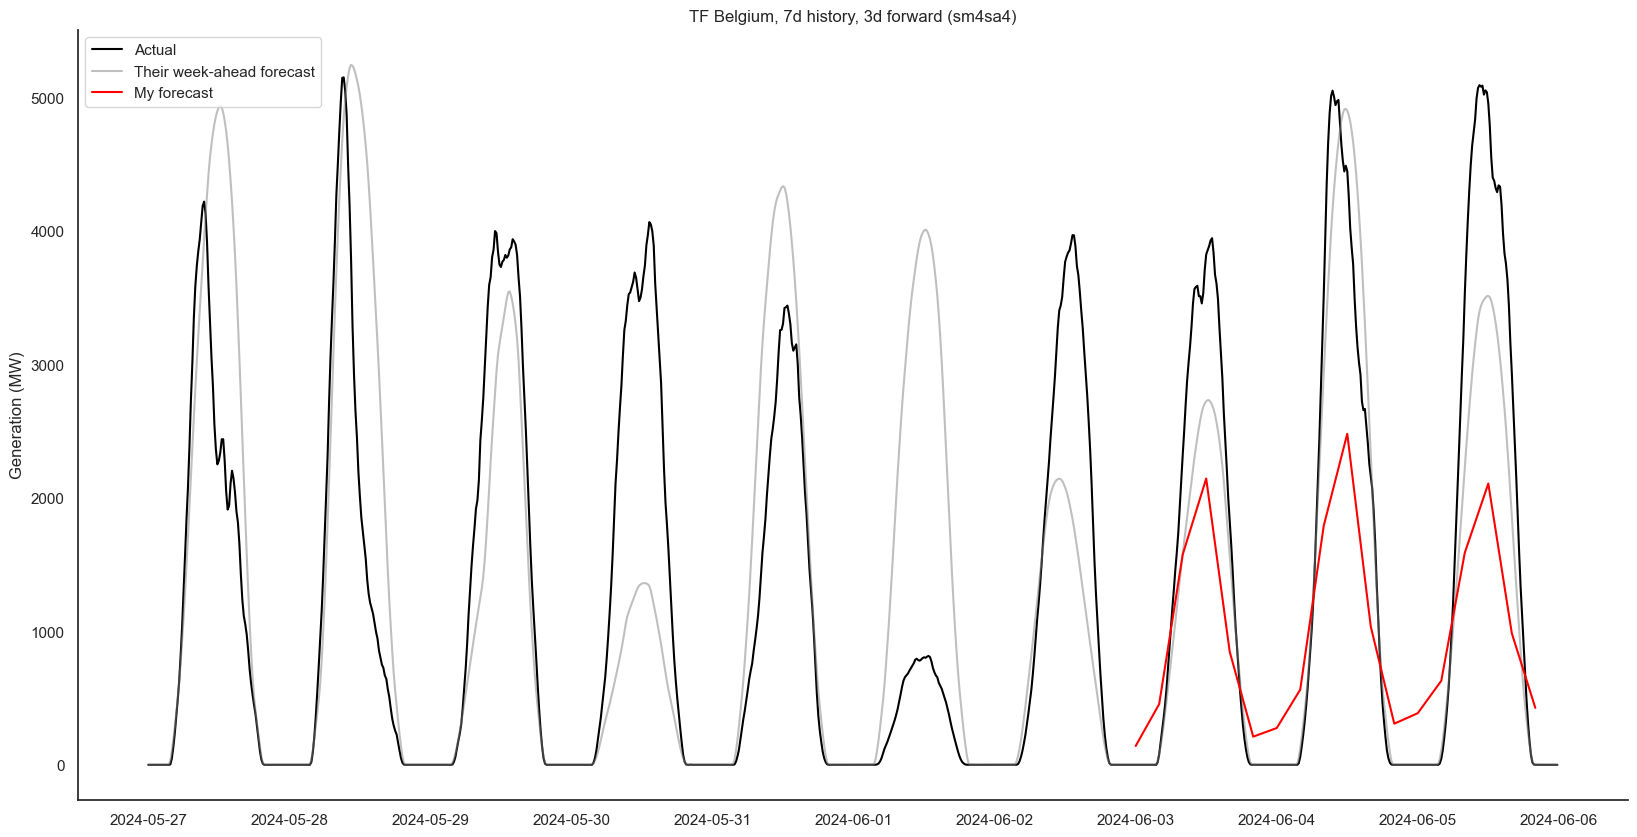

In [114]:
model_arima, pred_arima = run_model(df_in=df_be_arima, start=start, back=back, pred=pred, reduce='both', sm=sm, sa=sa, m=m, info=True, trace=True, stats=True, plot=True, plot_amount='all', plot_title=arima_plot_title, save=False, file_title=arima_file_title)

### Sliding window

In [10]:
# Chart upper limit
df_be_arima.measured['2022-01-01':'2023-12-31'].max()

5709.982

In [ ]:
# 30/14/7 to 7/1 predictions
# new function to do multiple predictions with same model, split predict into separate function?

back = 14
pred = 0
sm = 2
sa = 2
m = int(96/4/sa)
date_array = pd.date_range(start='2022-04-02', end='2022-12-31', freq='D').strftime('%Y-%m-%d').tolist()
# print(len(date_array))

for date in tqdm(date_array, desc="Processing ARIMA models"):
    arima_file_title = f'C:/Users/jgibb/Downloads/slide/new/belgium_{date}_{back}d_arima_sm{sm}sa{sa}'
    # arima_plot_title = f'Belgium, {back}d history, {pred}d forward (sm{sm}sa{sa})'
    run_model(df_in=df_be_arima, start=date, back=back, pred=pred, reduce='both', sm=sm, sa=sa, m=m, info=False, trace=False, stats=False, plot=False, save=True, file_title=arima_file_title)

In [67]:
def create_sequences(data, days):
    """
    Create input-output pairs for time series data for an LSTM model.
    
    Parameters:
    - data: Array-like time series data.
    - seq_len: Length of each input sequence.
    
    Returns:
    - X: Array of input sequences of shape (num_samples, seq_len, 1).
    - y: Array of target values of shape (num_samples, 1).
    """
    X, y = [], []
    
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    
    # Convert to numpy arrays and reshape for LSTM input
    X = np.array(X).reshape(-1, seq_len, 1)
    y = np.array(y).reshape(-1, 1)
    
    return X, y
    
df_be_arima_swcv = df_be_arima['2023-01-01':'2023-12-31']

train_window = 4 * 7 * 96
test_window = 7 * 96

errors = []

for start in range(0, len(df_be_arima_swcv) - train_window - test_window, test_window):
    train_data = df_be_arima_swcv.measured.values[start : start + train_window]
    test_data = df_be_arima_swcv.measured.values[start + train_window : start + train_window + test_window]

    X_train, y_train = create_sequences(train_data, seq_len)
    X_test, y_test = create_sequences(test_data, seq_len)

    model_arima.fit(X_train, y_train)
    predictions = model_arima.predict(X_test)

    error = mean_squared_error(y_test, predictions)
    errors.append(error)

print("Average Cross-Validation Error:", np.mean(errors))

## Keras

### Preprocess data

In [190]:
# start = '2024-01-01'
# back = (365*4)+1
# pred = 366
start = '2023-06-01'
back = 7
pred = 7
tf_file_title = f'tf_belgium_{start}_{back}d_{pred}d'
tf_plot_title = f'TF Belgium, one month history, one week forward'

# is this using GPU?

Back to 2023-05-31 23:45:00+00:00
Forward to 2023-06-07 23:45:00+00:00


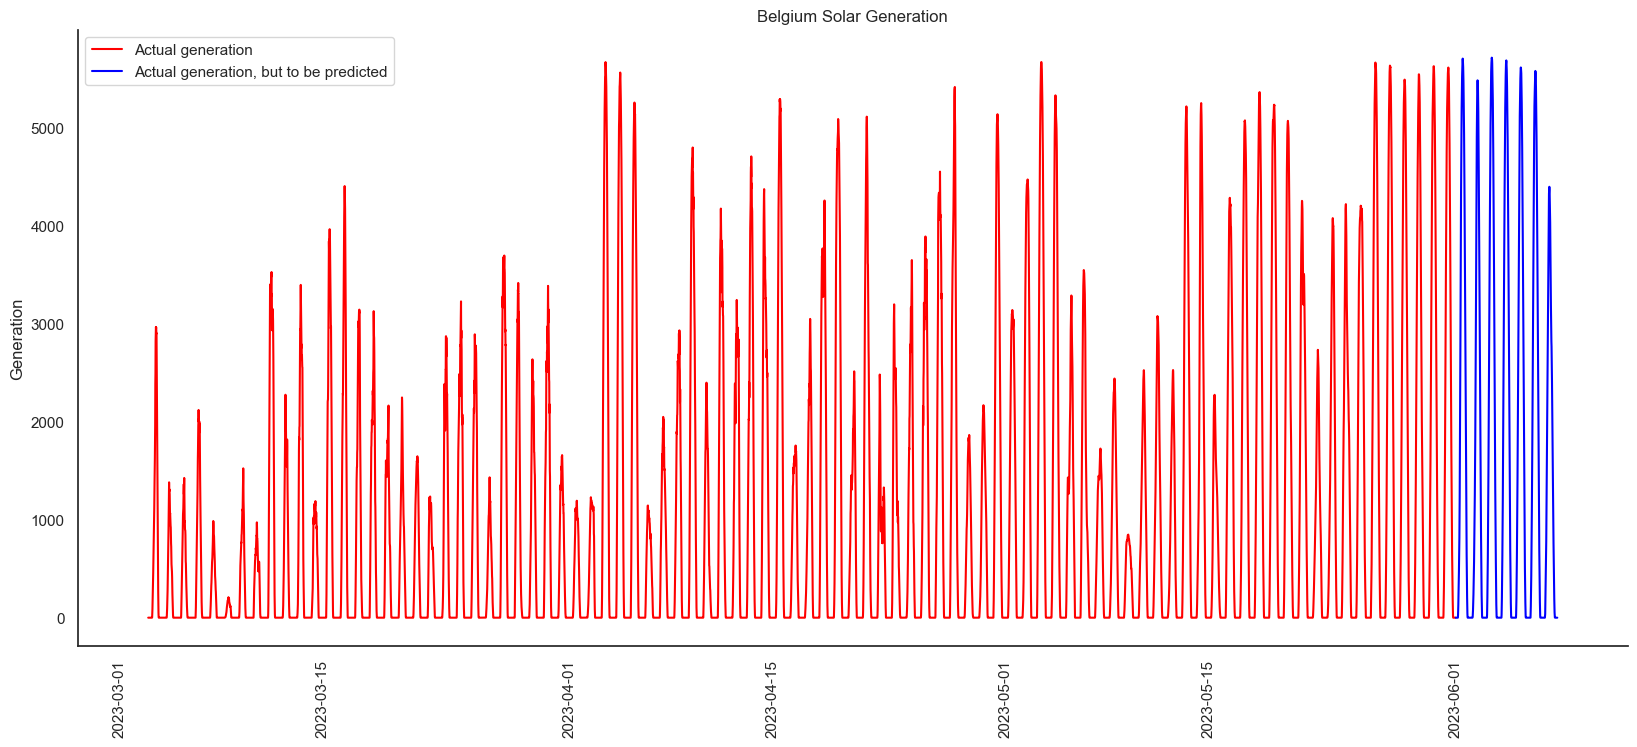

In [191]:
df_tf = df_be[['measured']].copy()
df_tf['day_of_year'] = df_tf.index.dayofyear / 365.0
df_tf['day_of_year_sin'] = np.sin(2 * np.pi * df_tf.index.dayofyear / 365)
df_tf['day_of_year_cos'] = np.cos(2 * np.pi * df_tf.index.dayofyear / 365)
df_tf['hour_sin'] = np.sin(2 * np.pi * df_tf.index.hour / 24)
df_tf['hour_cos'] = np.cos(2 * np.pi * df_tf.index.hour / 24)
df_tf_prescaled = df_tf.copy()

start_date = pd.to_datetime(start).tz_localize('UTC')
end_backward = start_date - pd.Timedelta(minutes=15)
print(f'Back to {end_backward}')
start_backward = end_backward - pd.Timedelta(days=back) + pd.Timedelta(minutes=15)
end_forward = start_date + pd.Timedelta(days=pred) - pd.Timedelta(minutes=15)
print(f'Forward to {end_forward}')

df_tf_bwd = df_tf_prescaled[start_backward:end_backward]
df_tf_fwd = df_tf_prescaled[start_date:end_forward]
df_tf_all = df_tf_prescaled[start_backward:end_forward]

plt.figure(figsize=(20,8))
sns.lineplot(df_tf_bwd.measured, color='red', label='Actual generation')
sns.lineplot(df_tf_fwd.measured, color='blue', label='Actual generation, but to be predicted')
sns.despine()
plt.title('Belgium Solar Generation')
plt.xlabel('')
plt.ylabel('Generation (MW)')
# plt.xlim(pd.to_datetime('2023-05-26'), pd.to_datetime('2023-06-07'))
plt.xticks(rotation=90)
plt.show()

def plot_losses(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [180]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_tf_bwd.measured = scaler.fit_transform(df_tf_bwd[['measured']])

seq_len = 96
num_features = len(df_tf_bwd.columns)

X, y = [], []
for i in range(seq_len, len(df_tf_bwd)):
    X.append(df_tf_bwd.iloc[i-seq_len:i].values)
    y.append(df_tf_bwd.iloc[i]['measured'])

X, y = np.array(X), np.array(y)

C:\Users\jgibb\AppData\Local\Temp\ipykernel_28400\2734455725.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tf_bwd.measured = scaler.fit_transform(df_tf_bwd[['measured']])


### Define models

In [192]:
model1 = Sequential([
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])

model2 = Sequential([
    LSTM(50, return_sequences=True),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])

model3 = Sequential([
    LSTM(100, return_sequences=True),
    LSTM(100),
    Dense(1)
])

model4 = Sequential([
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(1)
])

model5 = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_len, num_features)),
    MaxPooling1D(pool_size=2),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])

model6 = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_len, num_features)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model7 = Sequential([
    Bidirectional(LSTM(50, return_sequences=True, kernel_regularizer=l2(0.01)), input_shape=(seq_len, num_features)),
    Dropout(0.2),
    Bidirectional(LSTM(50, kernel_regularizer=l2(0.01))),
    Dropout(0.2),
    Dense(1)
])

models = {1:model1, 2:model2, 3:model3, 4:model4, 5:model5, 6:model6, 7:model7}
# models = {1:model1}

#### Find best model

In [ ]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, mode='min', restore_best_weights=True)
# scores = []

# for model_num, model in models.items():
#     print(f'Fitting model {model_num}')
#     model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
#     history = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)
#     scores.append({
#         'model': model_num,
#         'loss': history.history['loss'][-1], 
#         'val_loss': history.history['val_loss'][-1],
#         'delta': abs(history.history['loss'][-1] - history.history['val_loss'][-1])
#     })

# scores_df = pd.DataFrame(scores).sort_values('loss')
# display(scores_df)

# best_model_num = int(scores_df.iloc[0]['model'])
# best_model = models[best_model_num]
# best_model.save(f'{tf_file_title}_model{best_model_num}.h5')

In [83]:
# best_model = load_model('best_model.h5')

### Predict

In [ ]:
last_sequence = df_tf_bwd[-seq_len:].values
last_sequence = last_sequence.reshape((1, seq_len, last_sequence.shape[1]))

days_to_predict = pred
samples_per_day = 96
values_to_predict = days_to_predict * samples_per_day

predicted_values = []
for i in tqdm(range(days_to_predict * samples_per_day), desc="Predicting values"):
    predicted_value = best_model.predict(last_sequence, verbose=0)
    predicted_values.append(predicted_value[0, 0])
    
    next_day_of_year = ((df_tf_bwd.index[-1] + pd.Timedelta(minutes=(i + 1) * 15)).dayofyear / 365.0)
    next_hour_sin = np.sin(2 * np.pi * ((df_tf_bwd.index[-1] + pd.Timedelta(minutes=(i + 1) * 15)).hour) / 24)
    next_hour_cos = np.cos(2 * np.pi * ((df_tf_bwd.index[-1] + pd.Timedelta(minutes=(i + 1) * 15)).hour) / 24)
    next_day_of_year_sin = np.sin(2 * np.pi * next_day_of_year)
    next_day_of_year_cos = np.cos(2 * np.pi * next_day_of_year)
    new_sequence_step = np.array([[predicted_value[0, 0], next_day_of_year, next_hour_sin, next_hour_cos, next_day_of_year_sin, next_day_of_year_cos]])

    last_sequence = np.append(last_sequence[:, 1:, :], new_sequence_step.reshape(1, 1, new_sequence_step.shape[1]), axis=1)

predicted_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))

predicted_values_bak = predicted_values.copy()

In [85]:
predicted_values = predicted_values_bak.copy()

### Analysis

MSE	607.6624702208312
MSE	708666.1754976356
R^2	-0.3433476132412856


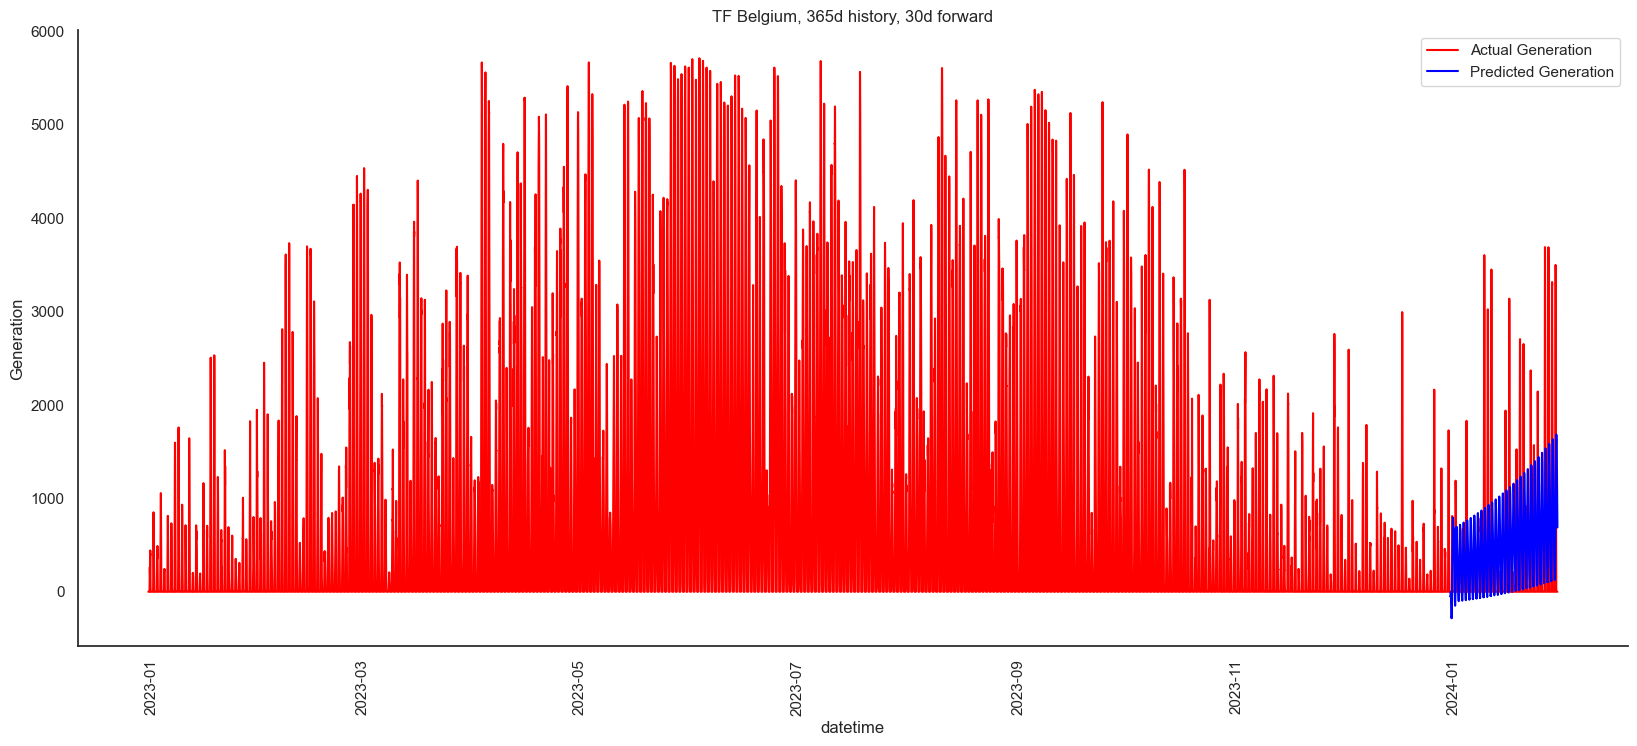

In [86]:
print(f'MSE\t{mean_absolute_error(df_tf_fwd.measured,predicted_values)}')
print(f'MSE\t{mean_squared_error(df_tf_fwd.measured,predicted_values)}')
print(f'R^2\t{r2_score(df_tf_fwd.measured,predicted_values)}')

plt.figure(figsize=(20,8))

sns.lineplot(data=df_tf_all.measured, label='Actual Generation', color='red')

# predicted_values = np.maximum(predicted_values, 0)

shift_amount = 0
crop_amount = 0
scale = 1

predicted_index = pd.date_range(start=df_tf_bwd.index[-1] + pd.Timedelta(minutes=15) + pd.Timedelta(hours=shift_amount), periods=len(predicted_values), freq='15min')
predicted_values_cropped = scale*predicted_values[crop_amount:]
predicted_index_cropped = predicted_index[crop_amount:]

sns.lineplot(x=predicted_index_cropped, y=predicted_values_cropped.flatten(), label='Predicted Generation', color='blue')
# plt.xlim(pd.to_datetime('2019-01-01'), pd.to_datetime('2025-01-01'))
sns.despine()
plt.ylabel('Generation (MW)')
plt.xticks(rotation=90)
plt.title(tf_plot_title)
plt.savefig(tf_file_title, bbox_inches='tight', transparent=True)
plt.show()

### Predict and analyse multiple models

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, mode='min', restore_best_weights=True)

for model_num, model in models.items():
    print(f'Fitting model {model_num}')
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    history = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)
    last_sequence = df_tf_bwd[-seq_len:].values
    last_sequence = last_sequence.reshape((1, seq_len, last_sequence.shape[1]))
    days_to_predict = pred
    samples_per_day = 96
    values_to_predict = days_to_predict * samples_per_day
    predicted_values = []
    for i in tqdm(range(days_to_predict * samples_per_day), desc="Predicting values"):
        predicted_value = model.predict(last_sequence, verbose=0)
        predicted_values.append(predicted_value[0, 0])
        next_day_of_year = ((df_tf_bwd.index[-1] + pd.Timedelta(minutes=(i + 1) * 15)).dayofyear / 365.0)
        next_hour_sin = np.sin(2 * np.pi * ((df_tf_bwd.index[-1] + pd.Timedelta(minutes=(i + 1) * 15)).hour) / 24)
        next_hour_cos = np.cos(2 * np.pi * ((df_tf_bwd.index[-1] + pd.Timedelta(minutes=(i + 1) * 15)).hour) / 24)
        next_day_of_year_sin = np.sin(2 * np.pi * next_day_of_year)
        next_day_of_year_cos = np.cos(2 * np.pi * next_day_of_year)
        new_sequence_step = np.array([[predicted_value[0, 0], next_day_of_year, next_hour_sin, next_hour_cos, next_day_of_year_sin, next_day_of_year_cos]])
        last_sequence = np.append(last_sequence[:, 1:, :], new_sequence_step.reshape(1, 1, new_sequence_step.shape[1]), axis=1)
    predicted_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))
    # predicted_values_bak = predicted_values.copy()
    print(f'MSE\t{mean_absolute_error(df_tf_fwd.measured,predicted_values)}')
    print(f'MSE\t{mean_squared_error(df_tf_fwd.measured,predicted_values)}')
    print(f'R^2\t{r2_score(df_tf_fwd.measured,predicted_values)}')
    plt.figure(figsize=(20,8))
    sns.lineplot(data=df_tf_all.measured, label='Actual Generation', color='red')
    # predicted_values = np.maximum(predicted_values, 0)
    predicted_index = pd.date_range(start=df_tf_bwd.index[-1] + pd.Timedelta(minutes=15), periods=len(predicted_values), freq='15min')
    sns.lineplot(x=predicted_index, y=predicted_values.flatten(), label='Predicted Generation', color='blue')
    sns.despine()
    plt.ylabel('Generation (MW)')
    plt.xticks(rotation=90)
    tf_plot_title = f'TF Belgium, three months history, one week forward, model {model_num}'
    plt.title(tf_plot_title)
    tf_file_title = f'tf_belgium_20230601_90d_7d_model{model_num}'
    plt.savefig(tf_file_title, bbox_inches='tight', transparent=True)
    plt.show()


# Combinations

## Import models

In [ ]:
combo_year = 2022
days_to_predict=1

In [71]:
date_array = pd.date_range(start=f'{combo_year}-01-01', end=f'{combo_year}-12-31', freq='D').strftime('%Y-%m-%d').tolist()
models = []
for date in date_array:
    models.append(pickle.load(open(f'C:/Users/jgibb/Downloads/slide/new/belgium_{date}_7d_arima_sm2sa2.pkl','rb')))
len(models)

365

## Predictions

In [72]:
import_sa=2
n_per = int((96/4/import_sa)*days_to_predict)
preds = []
for i in tqdm(range(len(models)), desc="Predicting values"):
    for model in models:
        preds.append(model.predict(n_periods=n_per))
print(len(preds))

Predicting values:   0%|          | 0/365 [00:00<?, ?it/s]

Predicting values: 100%|██████████| 365/365 [19:19<00:00,  3.18s/it]

133225


In [73]:
# preds_2022_7d_3d = preds.copy()
# preds_2023_7d_3d = preds.copy()
# preds_2023_7d_7d = preds.copy()
# preds_2022_7d_7d = preds.copy()

# preds = preds_2023_7d_7d.copy()

try:
    with open(f'C:/Users/jgibb/Downloads/slide/new/preds-{combo_year}-7d-{days_to_predict}d.pkl', 'wb') as f:
        pickle.dump(preds, f)
except OSError as e:
    print("Error:", e)
# with open('preds.pkl', 'rb') as f:
#     preds = pickle.load(f)

In [75]:
chunk_size = n_per
chunked_df = []
for i in tqdm(range(0, len(preds), chunk_size), desc="Concatenating chunks"):
    chunk = pd.concat(preds[i:i + chunk_size], axis=1, join='outer')
    chunked_df.append(chunk)
df_preds = pd.concat(chunked_df, axis=1)

average_preds_series = df_preds.mean(axis=1) # average the values for each date
average_preds_df = average_preds_series.to_frame(name='prediction') # convert to dataframe

Concatenating chunks: 100%|██████████| 3701/3701 [01:52<00:00, 32.93it/s]


## Compare with actual

In [77]:
average_actuals = df_be_arima[average_df.iloc[0].name.strftime('%Y-%m-%d'):average_df.iloc[-1].name.strftime('%Y-%m-%d')].copy()
average_actuals = average_series_actuals.resample('2h').mean()

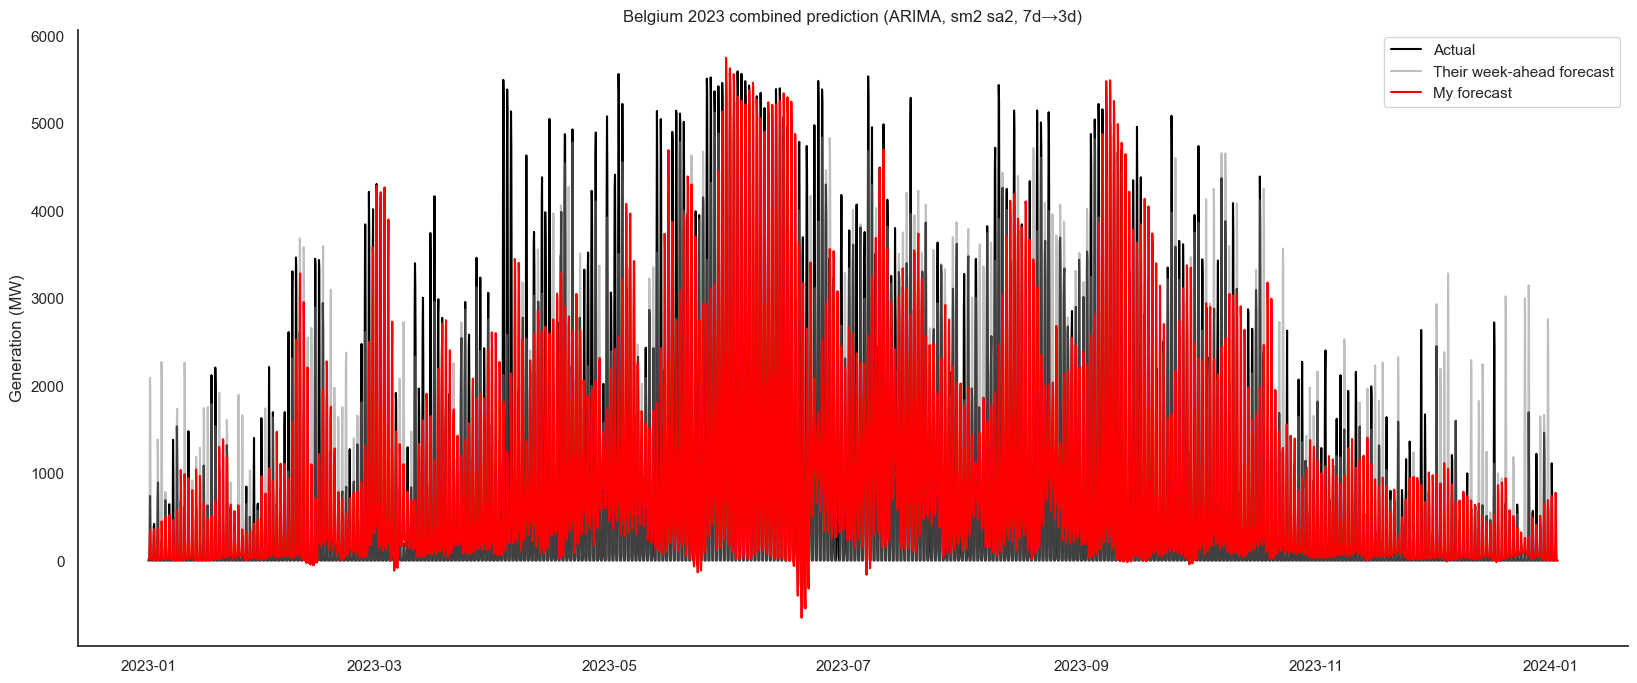

Mean		817.96
Median		335.07
Mode		20.41
Std Dev		1079.01
Mean Error	-0.54
Median Error	-64.9
Mode Error	-198.17
Error Std Dev	679.08
Max Error	4141.59
MAE		397.96
MSE		461048.13
RMSE		679.01
MA%E		430551.56
R²		0.73
None


In [80]:
plt.figure(figsize=(20,8))
sns.lineplot(average_actuals.measured, color = 'black', label='Actual')
sns.lineplot(average_actuals.forecast_week, color='grey', alpha=0.5, label='Their week-ahead forecast')
sns.lineplot(average_preds_df.prediction, color = 'red', label='My forecast')
sns.despine()
plt.xlabel('')
plt.ylabel('Generation (MW)')
plt.legend()
plt.title(f'Belgium {combo_year} combined prediction (ARIMA, sm2 sa2, 7d→{days_to_predict}d)')
plt.savefig(f'C:/Users/jgibb/Downloads/slide/new/belgium-{combo_year}-combined-prediction-arima-sm2sa2-7d-{days_to_predict}d', bbox_inches='tight', transparent=True)
plt.show()

print(preds_vs_actual_stats_df(average_preds_df.prediction, average_series_actuals[0].forecast_week))